# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
from pymer4.models import lmer, lm, glmer, compare
from pymer4 import config
import polars
import statsmodels.api as sm
import senepy
import gseapy as gp
import pertpy as pt
import warnings
import scanpy as sc
import pandas as pd
import numpy as np
import scflow
from scflow.ax import find_senescence_genes, run_senepy

# Display Settings
pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 300)
mpl.rcParams["figure.dpi"] = 200
warnings.filterwarnings(
    "ignore", message="Bitwise inversion '~' on bool is deprecated",
    category=DeprecationWarning)

# If You Want Results Emailed (Will Overwrite HTML Regardless of `overwite`)
cur_file = os.path.join(os.path.abspath(""), "data_diagnostics_613.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Cell Type Label Column
col_celltype = "annotation_scanvi"
# col_celltype = "annotation_by_overlap"
# col_celltype = "Annotation_ToppGene"
# col_celltype = "cellmap_class_name"
# col_celltype = "cellmap_class_name_collapsed"

# Metadata Information
species = "Mouse"
col_sample, col_batch = "sample", "Group"
# col_age = "Characteristics[Age at Euthanasia]"
# col_condition = "Factor Value[Spaceflight]"
col_age = "Age_End"
col_condition = "Condition"
group_order = ["Ground Control | 20 Weeks", "Ground Control | 37 Weeks",
               "Space Flight | 20 Weeks", "Space Flight | 37 Weeks"]
# group_order = ["Ground Control | 20 Weeks", "Ground Control | 37 Weeks",
#                "Space Flight | 20 Weeks", "Space Flight | 37 Weeks"]
keys = {col_condition: dict(key_control="Ground Control",
                            key_treatment="Space Flight"),
        # col_age: dict(key_control="20 Weeks",
        #               key_treatment="37 Weeks"),
        col_age: dict(key_control="12 Weeks",
                      key_treatment="29 Weeks"),
        col_batch: dict(key_control=group_order[0],
                        key_treatment=group_order[1:])}
palette = {col_condition: {keys[col_condition]["key_control"]: "b",
                           keys[col_condition]["key_treatment"]: "r"},
           col_age: {keys[col_age]["key_control"]: "g",
                     keys[col_age]["key_treatment"]: "y"},
           col_batch: dict(zip(group_order, ["c", "b", "tab:pink", "r"]))}

# Markers
mks_a_priori = pd.read_csv("GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv")
mks_a_priori.loc[:, "cellName"] = mks_a_priori.cellName.replace({
    "Oligodendrocyte precursor cell": "OPC"}).apply(
        lambda x: " ".join([i.capitalize() for i in re.sub(
            " cell", "", x).split(" ")])).replace({
                "Opc": "OPC"})  # capitalize cell names
mks_a_priori = mks_a_priori.set_index("cellName")["geneSymbol"]
mks_a_priori = dict(mks_a_priori.apply(lambda x: set(x.split(","))))
mks_a_priori.update({
    "Neuroepithelial": {"Nes", "Notch1", "Sox2", "Sox10", "Hes1", "Hes3"},
    "Excitatory": {"Slc17a7", "Slc30a3", "Tcf4",
                   "Slc17a6", "Slc6a1", "Baiap3",
                   "Grin1", "Grin2b", "Gls"},
    "Inhibitory": {"Gad1", "Slc6a1", "Gabbr1", "Gabbr2",
                   "Gad2", "Slc32a1", "Oprm1", "Htr2c"},
    # "Glutamatergic": {"Slc17a7", "Slc17a6", "Grin1", "Grin2b", "Gls"},
    # "GABAergic": {"Slc6a1", "Gabbr1", "Gabbr2", "Gad2", "Gad1"},
    # "Dopaminergic": {"Th", "Dat", "Foxa2", "Girk2", "Nurr1", "Lmx1b"},
    # "Serotonergic": {"Tph", "Sert", "Pet1"},
    # "Cholinergic": {"ChAT", "VAChT", "Acetylcholinesterase"}
})
mks_collapsed = {**mks_a_priori}
mks_collapsed["Neuron"] = mks_collapsed["Neuron"].union(mks_collapsed[
    "Excitatory"]).union(mks_collapsed["Inhibitory"])
_ = mks_collapsed.pop("Excitatory")
_ = mks_collapsed.pop("Inhibitory")

# Scoring Metrics
use_metric = "senmayo"
percentile = 1

# File Input & Output
file_path = "data/OSD-613_integrated_analyzed.h5ad"

# Load Data
self = scflow.Rna(file_path, col_sample=col_sample, col_batch=col_batch,
                  col_celltype=col_celltype)  # data
self.rna.obs.loc[:, col_batch] = self.rna.obs[col_batch].astype(
    pd.CategoricalDtype(categories=group_order, ordered=True))
self.rna.obs.loc[:, "Spaceflight"] = (self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]).astype(int)  # 1 vs. 0 spaceflight
self.rna.obs.loc[:, "Aged"] = (self.rna.obs[col_age] == keys[
    col_age]["key_treatment"]).astype(int)  # 1 vs. 0 older
self.rna = self.rna[:, self.rna.var.mt == False]  # snRNA-seq so remove MT-
self.rna = self.rna[:, self.rna.var.ribo == False]  # snRNA-seq so remove RB-

# Hierarchical
keys_cts = {"Neuron": ["Excitatory", "Inhibitory", "Excitatory-Inhibitory"],
            "Macroglia": ["Oligodendrocyte", "OPC", "Astrocyte"],
            "Microglia": ["Microglial"]}
key_cts = dict(pd.concat([pd.Series(dict(([(i, x) for i in keys_cts[
    x]]))) for x in keys_cts]))
self.rna.obs.loc[:, f"{col_celltype}_hierarchy"] = self.rna.obs[
    col_celltype].replace(key_cts)
self.rna.raw = None

# Display Object
print(self.rna)
print(self.rna.obs.groupby(col_sample).describe())
self.rna.obs

# Number of Cells

In [20]:
%matplotlib inline

# Cells per Cluster
perc_clusters = round(100 * self.rna.obs.groupby(col_sample).value_counts(
    [col_celltype], normalize=True).unstack(1), 2)
print(f"\n\n*** Cell Composition (%) ***\n\n{perc_clusters}")

# Number of Cells
n_cells = self.rna.obs.groupby(col_sample).apply(
    lambda x: x.n_cells_original_sample.unique()[0],
    include_groups=False).to_frame("Original Cell N").join(
        self.rna.obs.groupby(col_sample).apply(
            lambda x: x.shape[0], include_groups=False).to_frame("N Cells"))
n_cells.loc[:, "Percent_Filtered"] = round(100 * (1 - n_cells[
    "N Cells"] / n_cells["Original Cell N"]), 2)
print("\n\n", n_cells.sort_values("Percent_Filtered"))



*** Cell Composition (%) ***

annotation_scanvi             Astrocyte  Endothelial  Microglial  Neuron   OPC  Oligodendrocyte
sample                                                                                         
RRRM2_BRN_GC_ISS-T_YNG_GY4         7.23         2.76        3.47   63.04  7.31            16.18
RRRM2_BRN_GC_ISS-T_YNG_GY9         9.13         1.32        3.37   65.51  3.44            17.24
RRRM2_BRN_GC_ISS-T_OLD_GO18        8.63         0.84        3.42   70.23  3.01            13.87
RRRM2_BRN_FLT_ISS-T_OLD_FO20       6.89         1.30        3.64   58.80  3.51            25.86
RRRM2_BRN_GC_ISS-T_OLD_GO19        6.53         0.77        3.41   67.28  3.46            18.56
RRRM2_BRN_GC_ISS-T_OLD_GO13        9.65         1.78        3.12   54.24  3.64            27.57
RRRM2_BRN_FLT_ISS-T_YNG_FY8        8.24         0.57        5.61   57.76  4.38            23.43
RRRM2_BRN_FLT_ISS-T_YNG_FY7        6.62         0.11        4.36   56.85  3.49            28.56
RRRM2_BR

# Markers

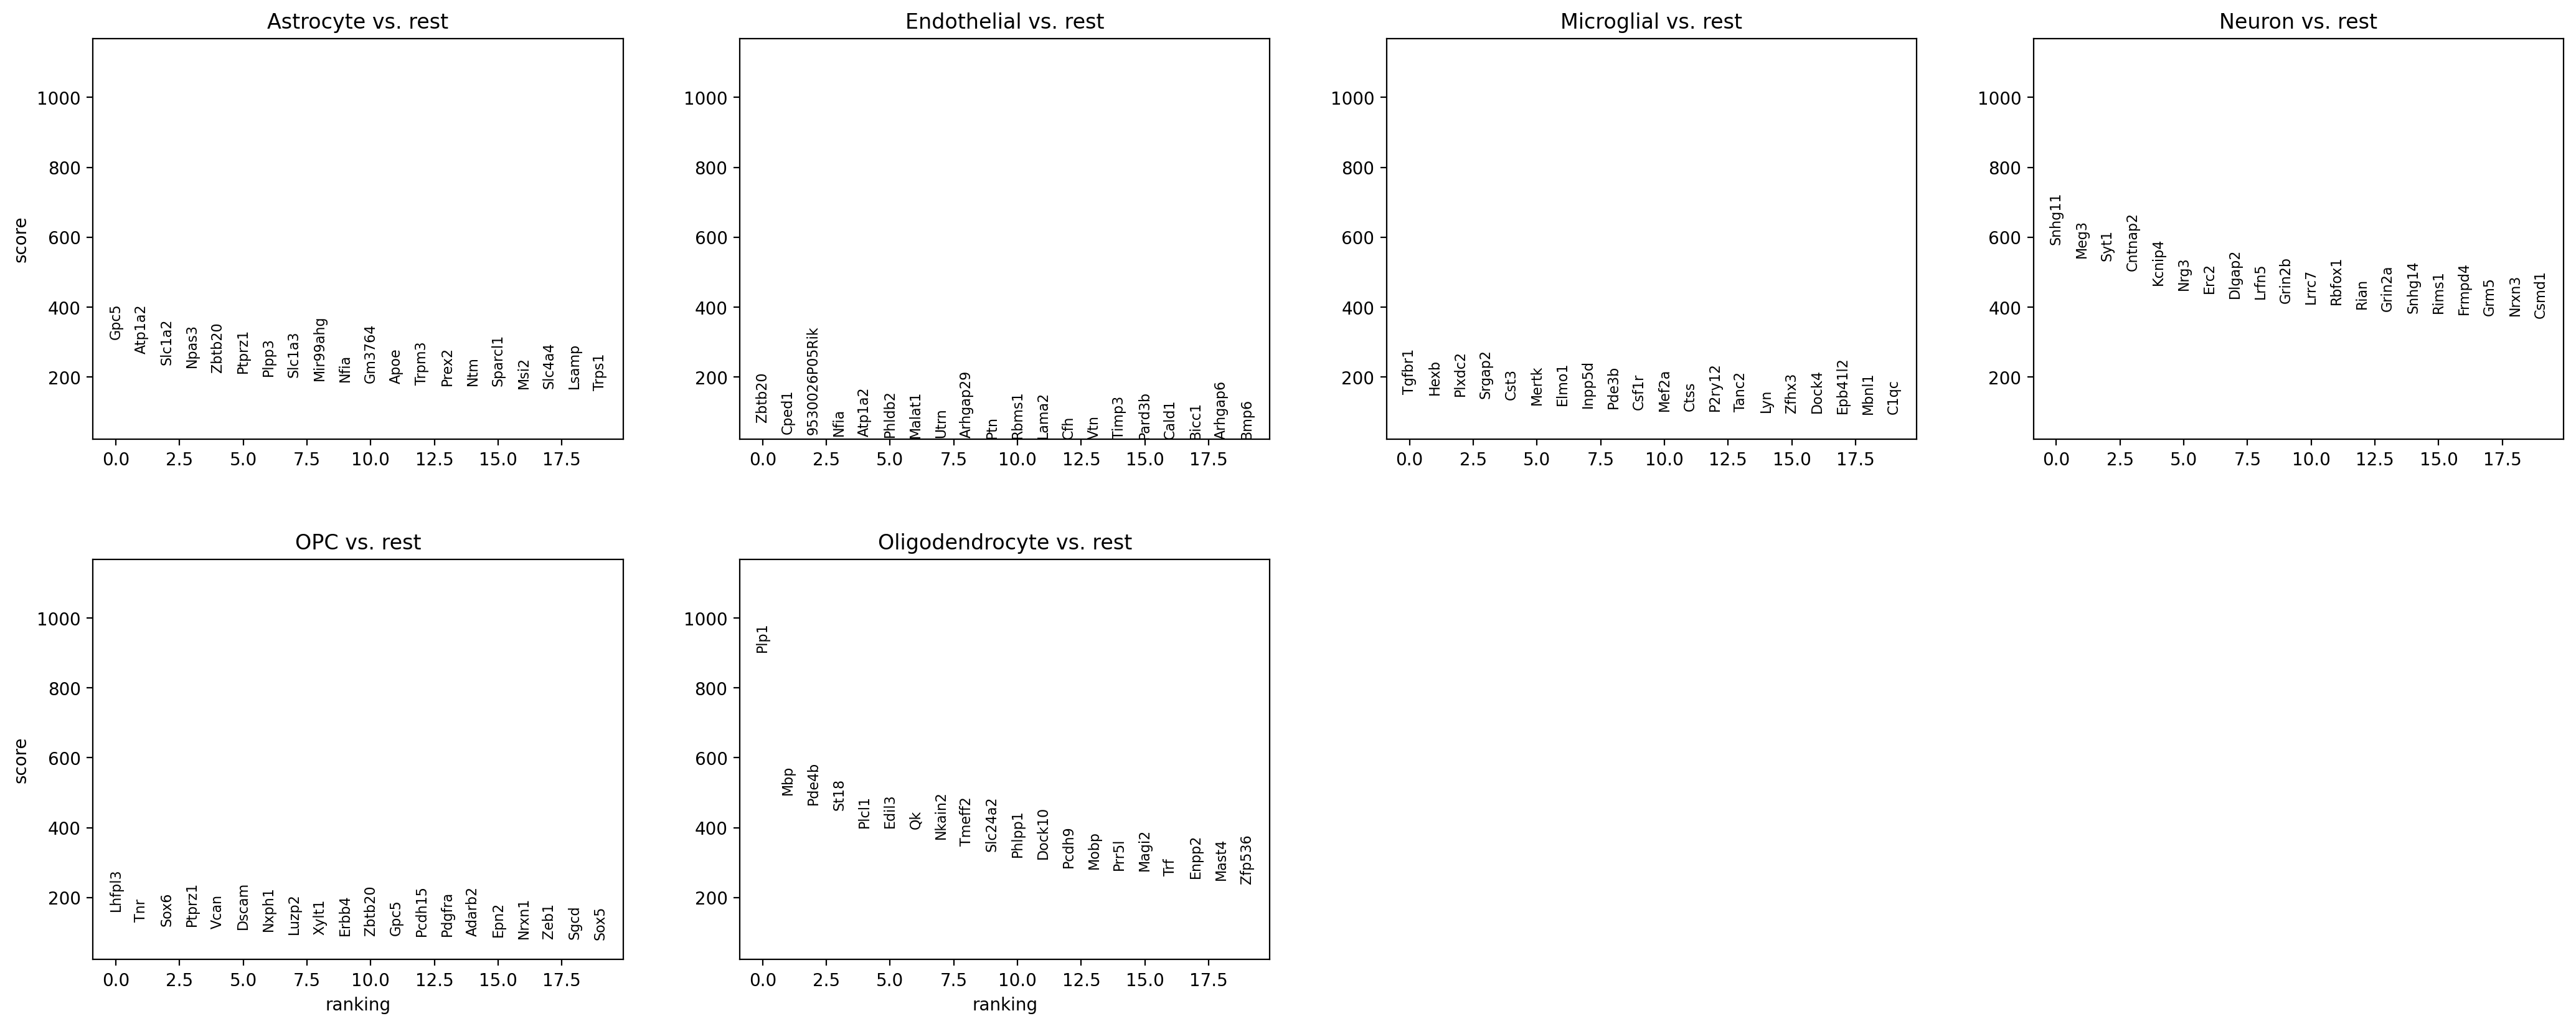

scores  logfoldchanges          pvals      pvals_adj
annotation_scanvi names                                                                  
Astrocyte         Bcl2            48.966312        2.244818   0.000000e+00   0.000000e+00
                  Abhd3           47.107872        3.003248   0.000000e+00   0.000000e+00
                  Ugp2            47.243469        2.251395   0.000000e+00   0.000000e+00
                  Aldh1l1         47.397026        4.863538   0.000000e+00   0.000000e+00
                  Dpf3            47.480507        3.191907   0.000000e+00   0.000000e+00
                  Ston2           47.728420        2.989743   0.000000e+00   0.000000e+00
                  Gm26512         47.993313        5.132370   0.000000e+00   0.000000e+00
                  Slc25a18        48.326790        5.366792   0.000000e+00   0.000000e+00
                  Fgfr1           48.550449        2.880157   0.000000e+00   0.000000e+00
                  Cd81            48.823803        1.728195   0.000000e+00   0.000000e+00
Endothelial       Zbtb20          71.523643        3.209239   0.000000e+00   0.000000e+00
                  Cped1           37.842743        7.205899  3.891507e-186  6.621035e-185
                  9530026P05Rik   34.913925        5.121674  7.849119e-168  1.249353e-166
                  Nfia            31.250296        2.654991  5.932817e-145  8.483368e-144
                  Atp1a2          30.081984        4.475922  4.779899e-137  6.555832e-136
                  Phldb2          29.014021        5.849259  4.505393e-130  5.989202e-129
                  Utrn            26.824389        3.151123  3.730099e-116  4.590337e-115
                  Arhgap29        26.134878        5.290306  1.224897e-111  1.461299e-110
                  Ptn             25.338373        2.747849  1.032207e-106  1.193748e-105
                  Rbms1           24.233679        2.625154   1.080025e-99   1.203044e-98
Microglial        Tgfbr1         151.537048        7.483766   0.000000e+00   0.000000e+00
                  Hexb           150.142044        5.966863   0.000000e+00   0.000000e+00
                  Plxdc2         145.446838        4.734621   0.000000e+00   0.000000e+00
                  Srgap2         137.973251        4.548377   0.000000e+00   0.000000e+00
                  Sparc           67.381912        5.038126   0.000000e+00   0.000000e+00
                  Sirpa           67.379906        3.609292   0.000000e+00   0.000000e+00
                  Slco2b1         66.709709        8.704315   0.000000e+00   0.000000e+00
                  Rreb1           66.396027        4.513351   0.000000e+00   0.000000e+00
                  Gab2            66.023293        3.442952   0.000000e+00   0.000000e+00
                  Runx1           65.527824        8.830940   0.000000e+00   0.000000e+00
Neuron            Pde7a           56.121979        1.154942   0.000000e+00   0.000000e+00
                  Chic1           55.948746        1.314887   0.000000e+00   0.000000e+00
                  Pkig            55.969212        1.236063   0.000000e+00   0.000000e+00
                  Tacc2           55.974857        1.825886   0.000000e+00   0.000000e+00
                  Slc27a2         56.000706        4.424804   0.000000e+00   0.000000e+00
                  Arc             56.007168        2.253946   0.000000e+00   0.000000e+00
                  Sesn3           56.009090        1.102200   0.000000e+00   0.000000e+00
                  Pnma8a          56.043762        2.091939   0.000000e+00   0.000000e+00
                  Gm44518         56.048363        3.546906   0.000000e+00   0.000000e+00
                  Gm15997         56.082333        4.612058   0.000000e+00   0.000000e+00
OPC               Lhfpl3         161.057190        5.147624   0.000000e+00   0.000000e+00
                  Tnr            131.139984        4.126481   0.000000e+00   0.000000e+00
                  Sox6           118.223061        5.241720   0.000000e+00   

In [21]:
self.find_markers(col_celltype=col_celltype)
df_degs = self.get_markers_df(
    n_genes=50, col_celltype=col_celltype,
    log2fc_threshold=1, p_threshold=1e-10)
df_degs.groupby(col_celltype).apply(
    lambda x: x.head(10)).reset_index(0, drop=True)

## *A Priori* Marker GEX

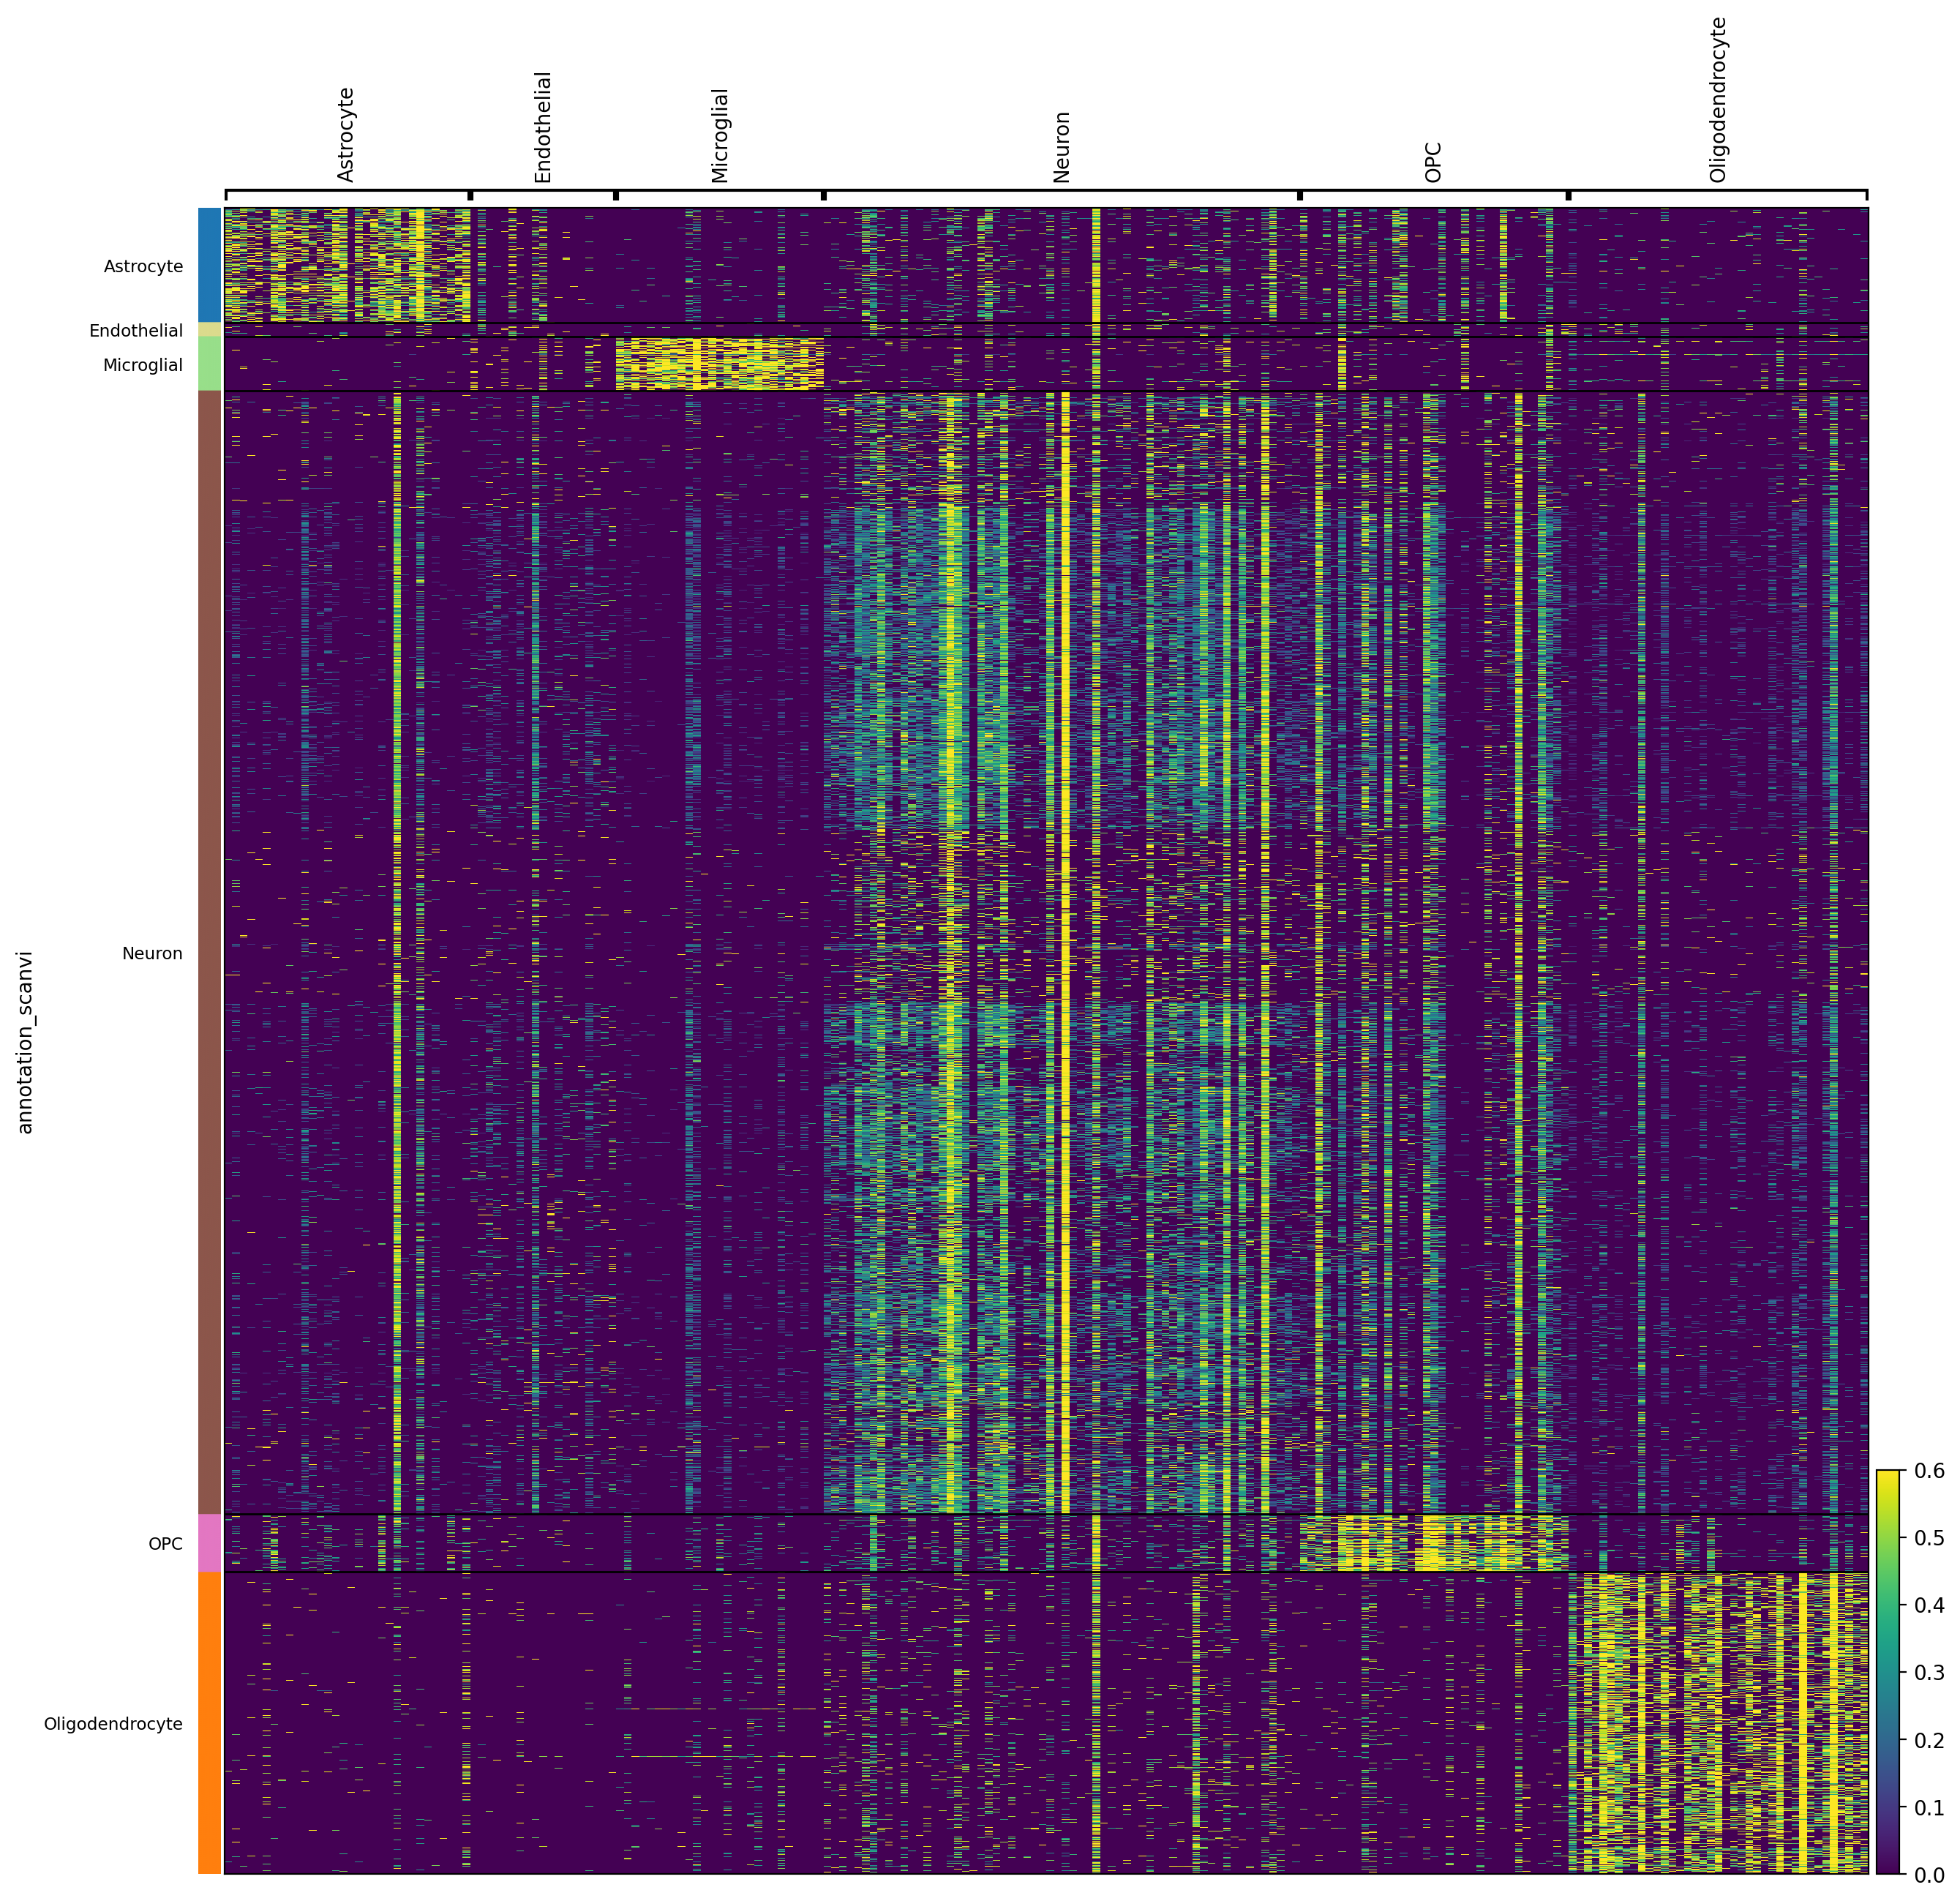

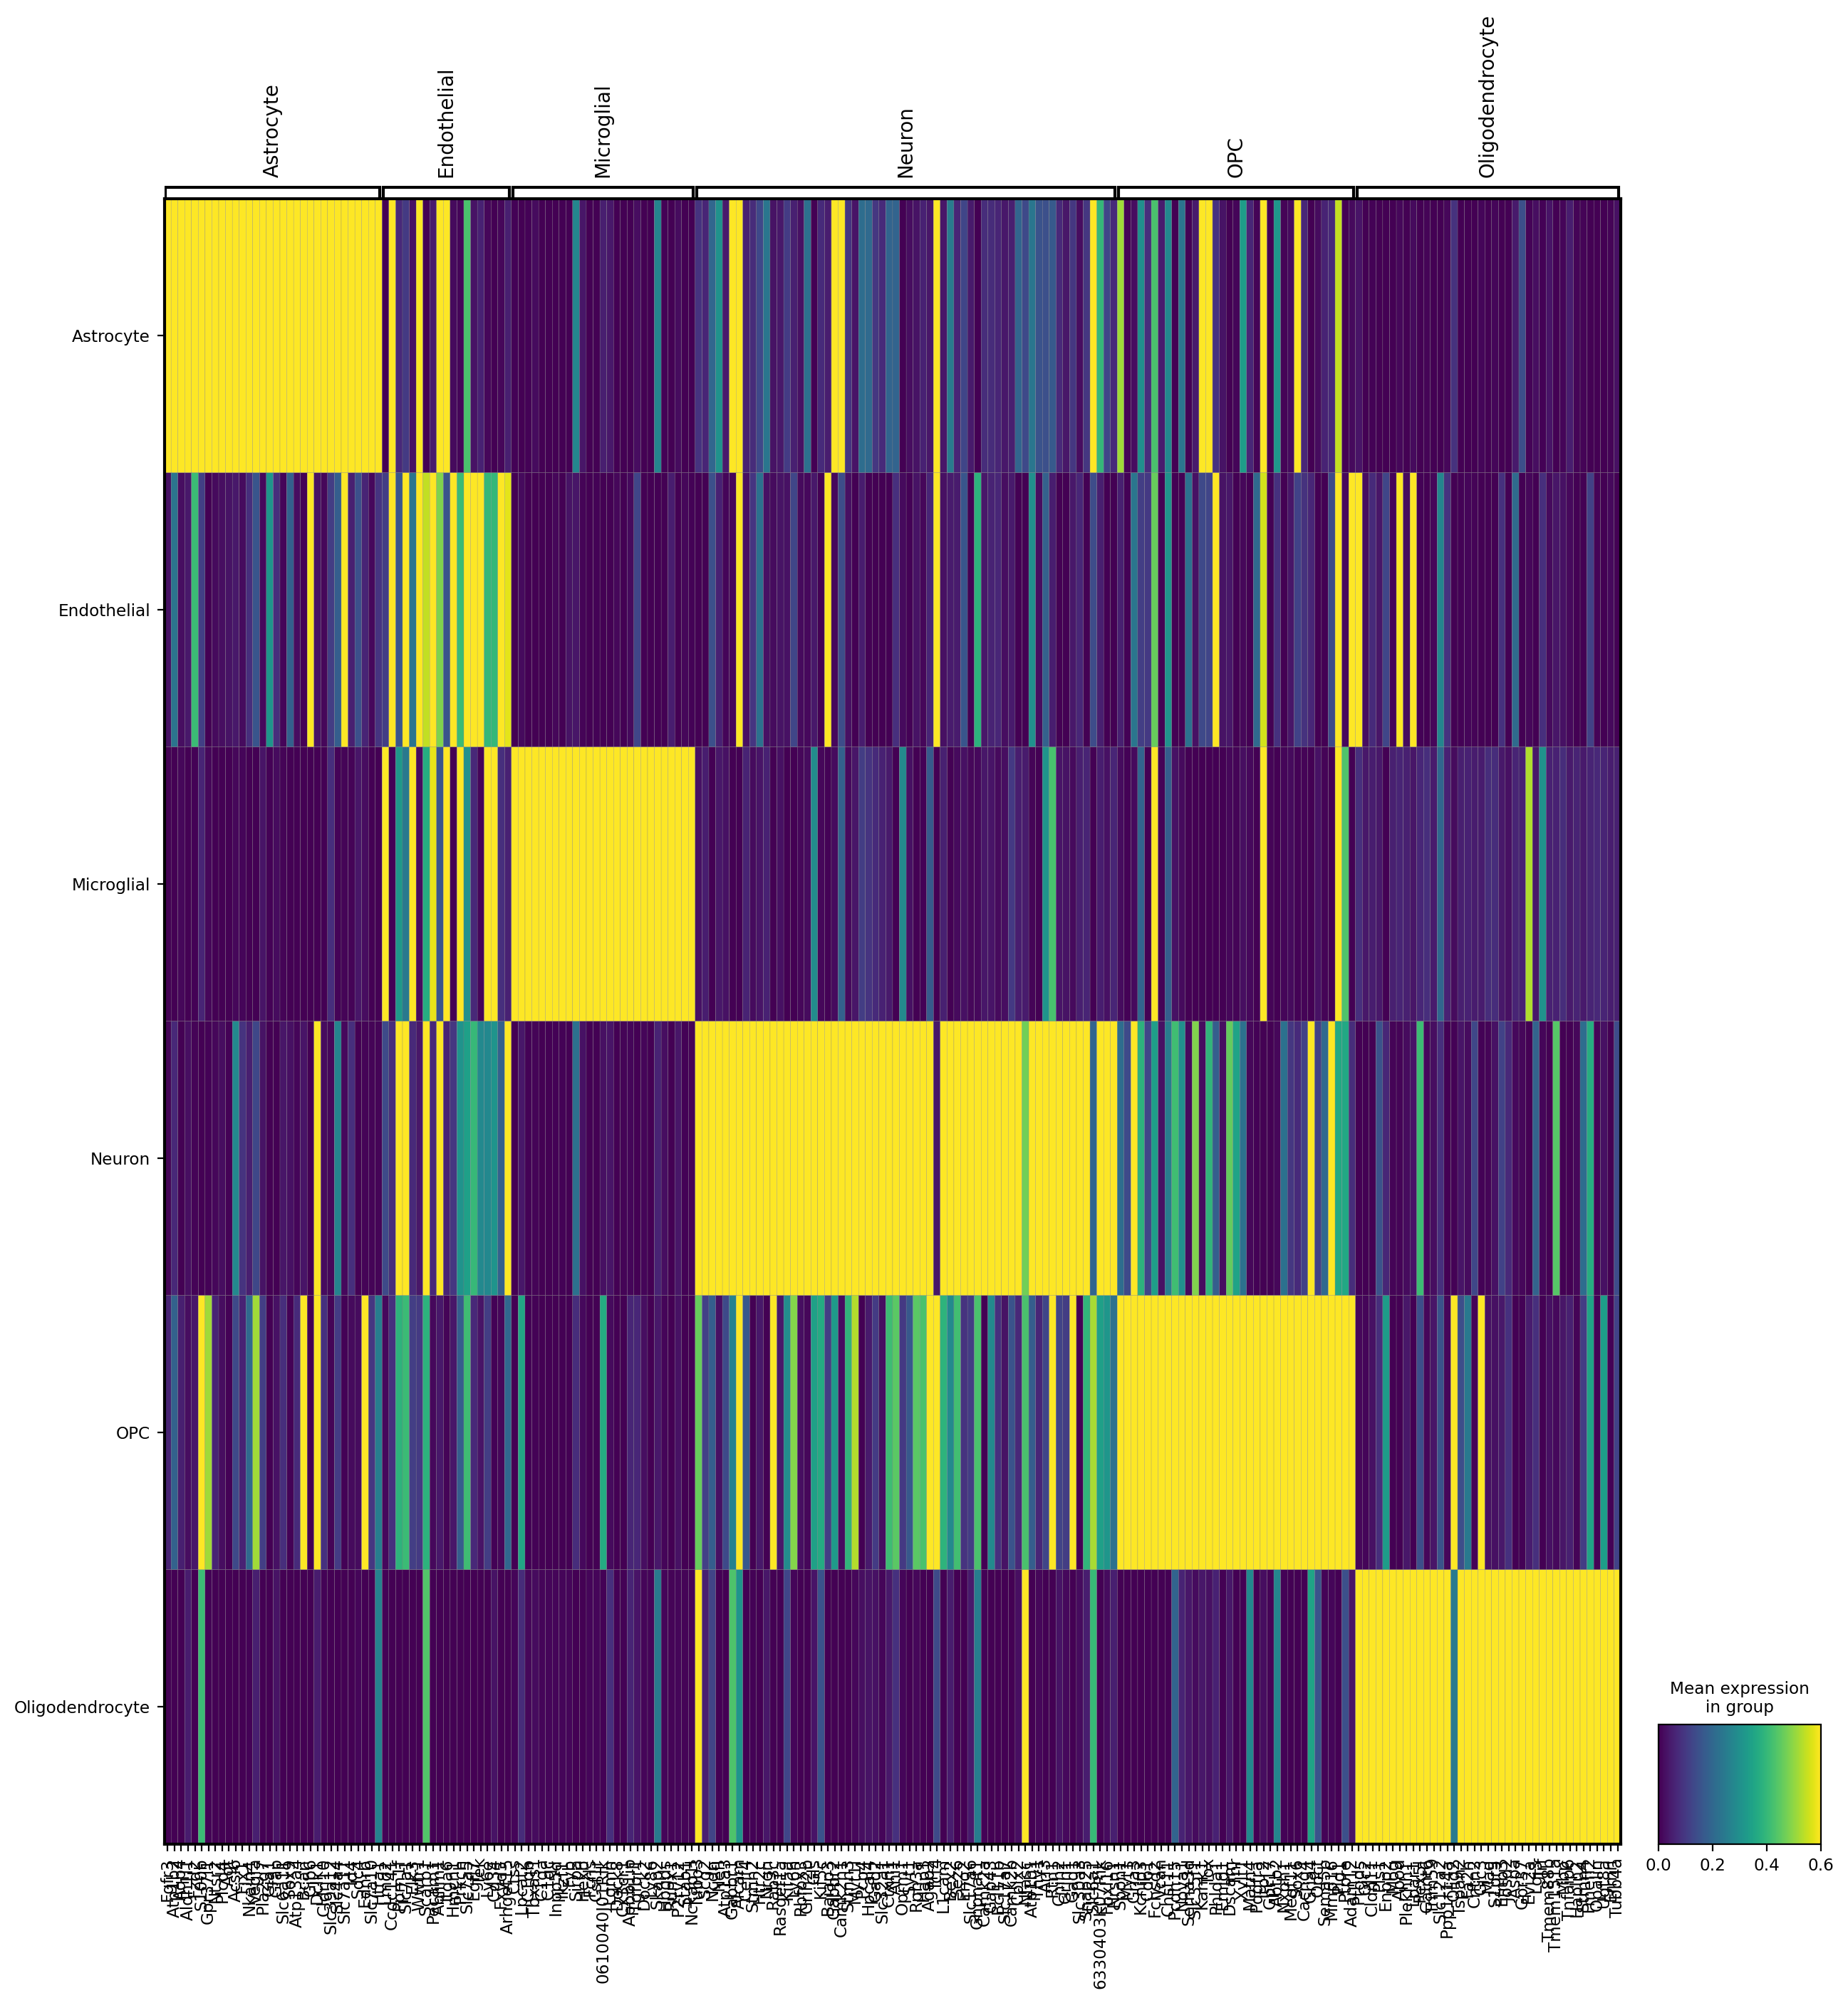

In [27]:
cct = col_celltype
# cct = "annotation_by_markers_individual"
mks_col = dict(zip(self.rna.obs[cct].cat.categories, [list(
    mks_collapsed[x].intersection(self.rna.var_names)
    ) for x in self.rna.obs[cct].cat.categories]))
_ = self.plot(genes=mks_col, figsize=(15, 15), col_celltype=col_celltype,
              layer="scaled", standard_scale="var",
              vmax=0.6, kind=["heat", "matrix"])

## Marker GEX Group Comparison

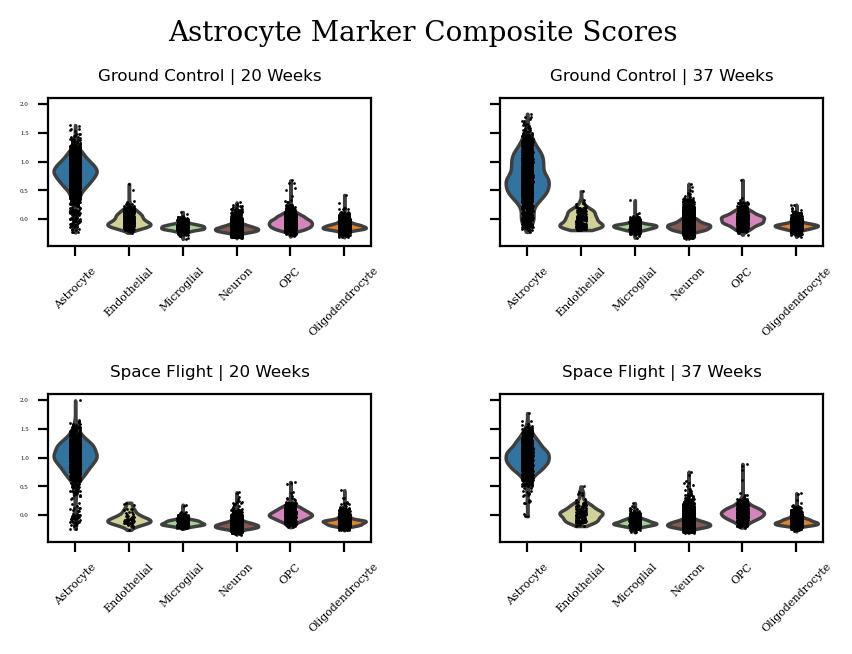

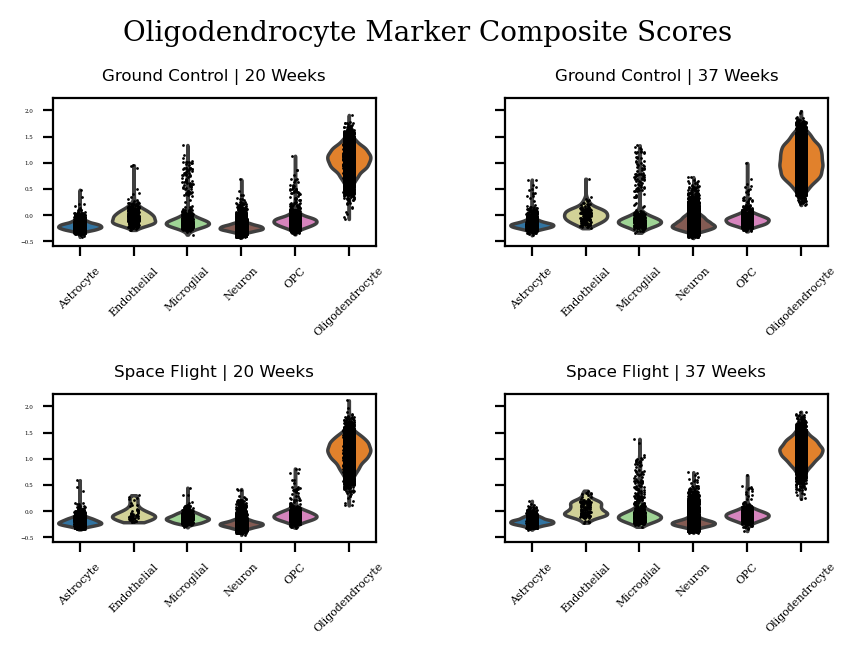

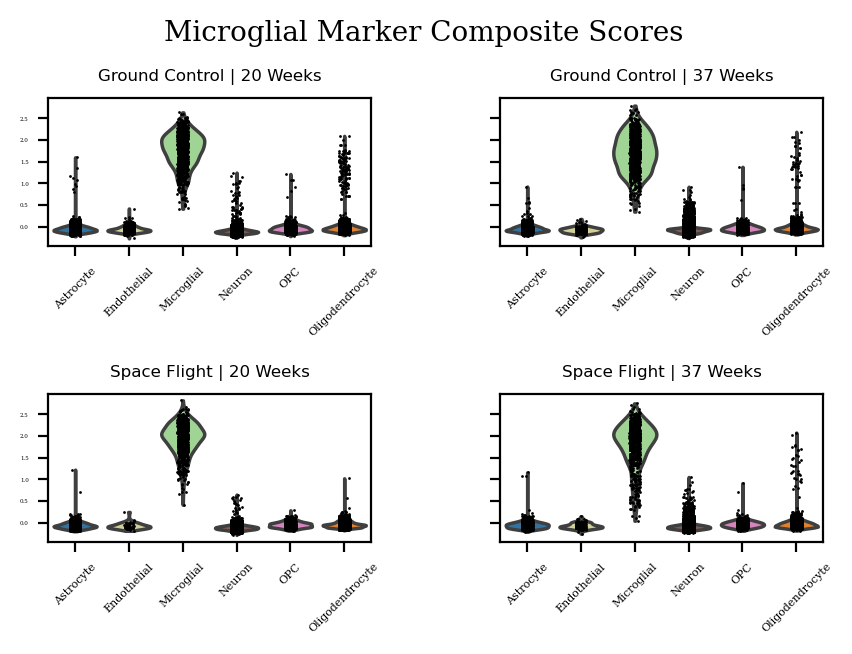

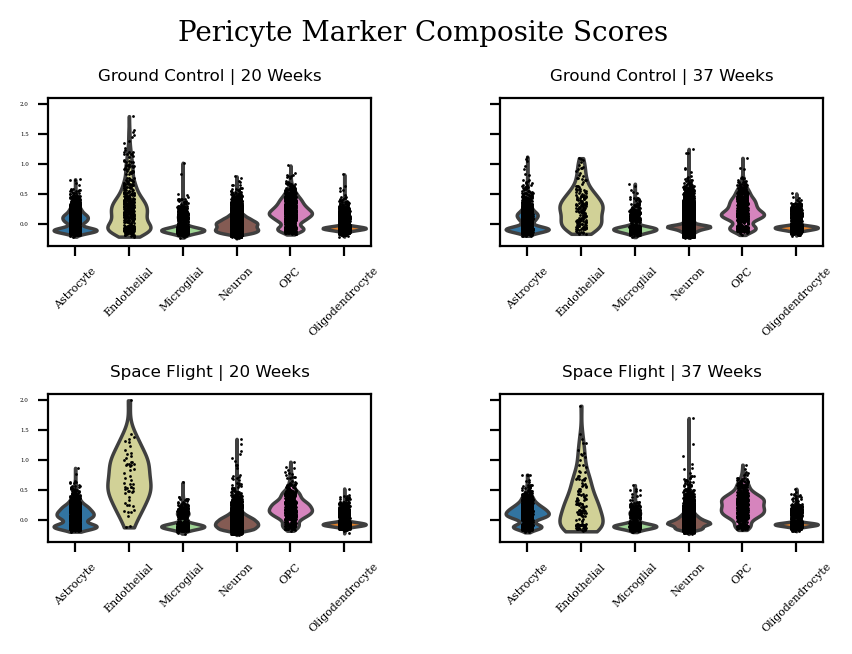

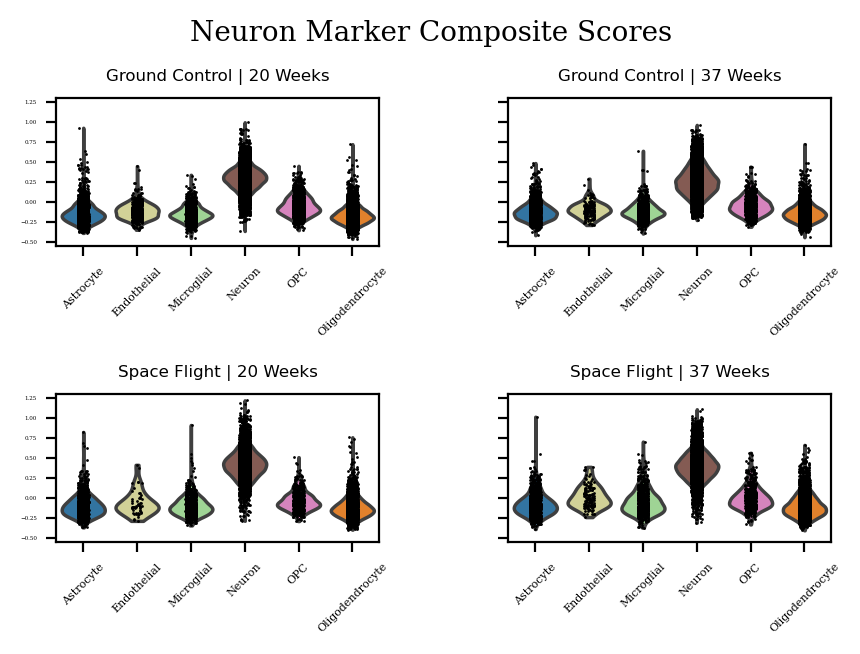

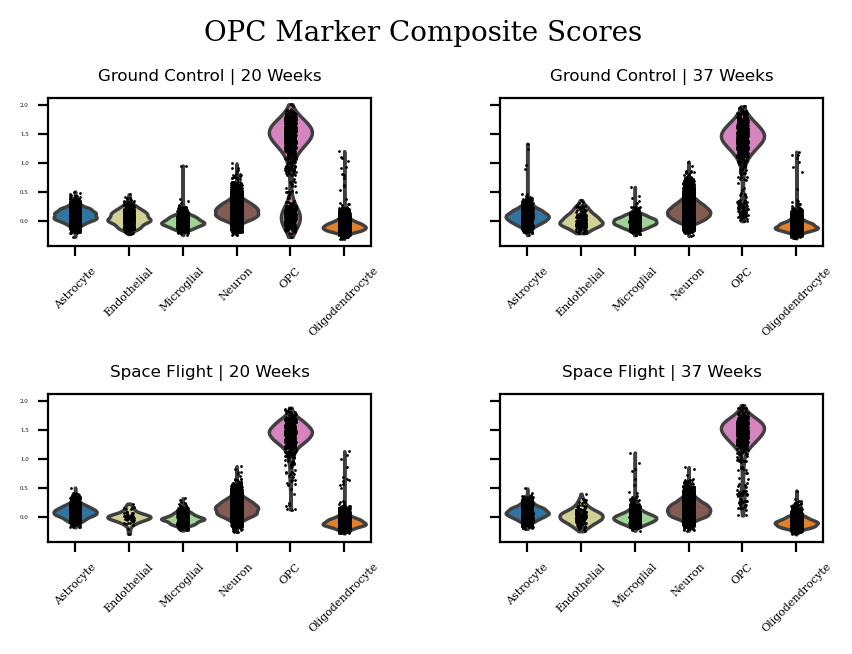

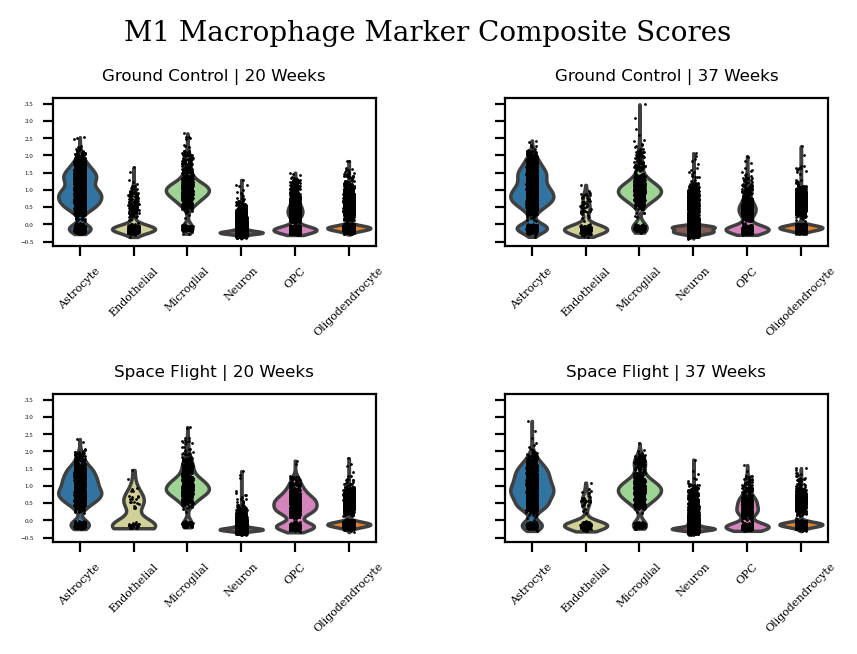

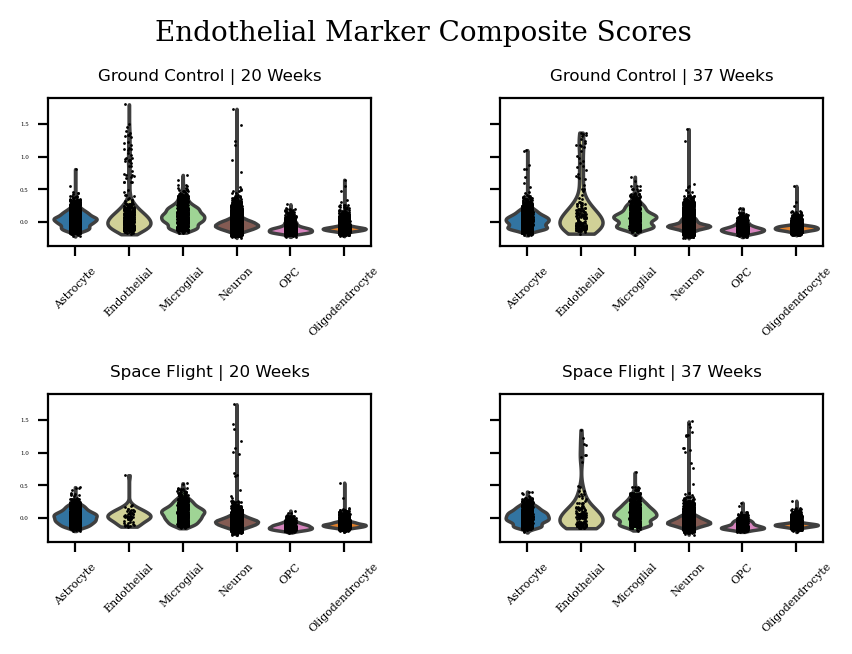

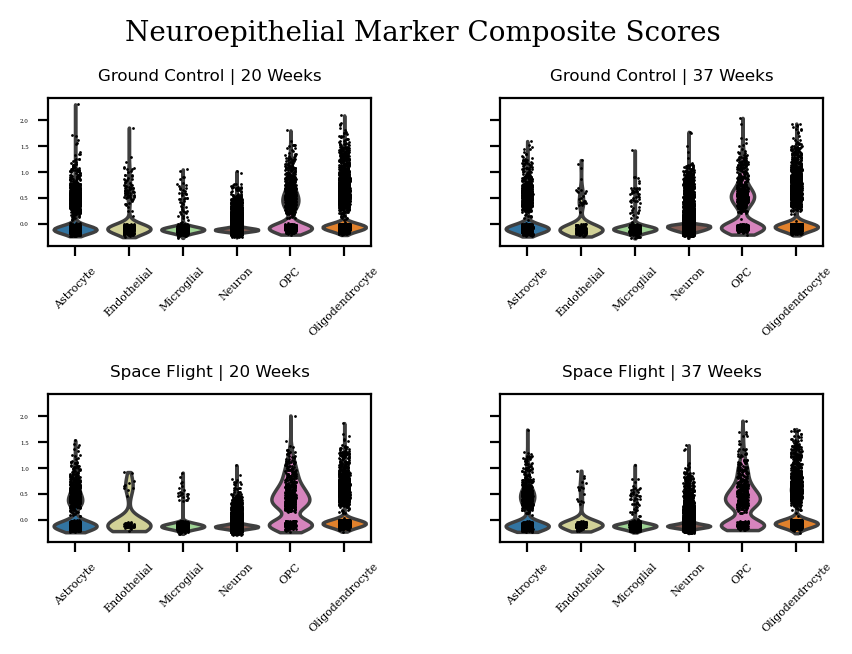

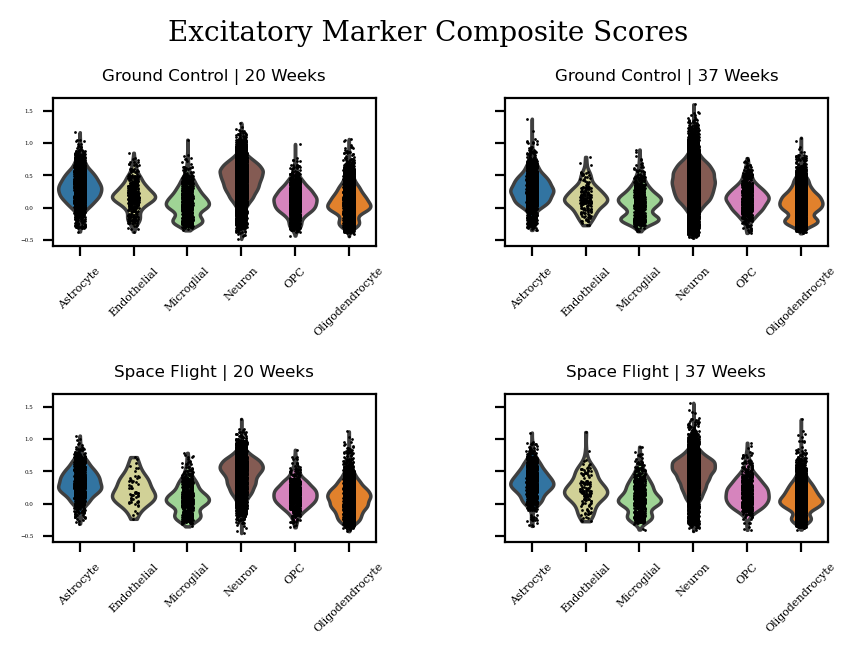

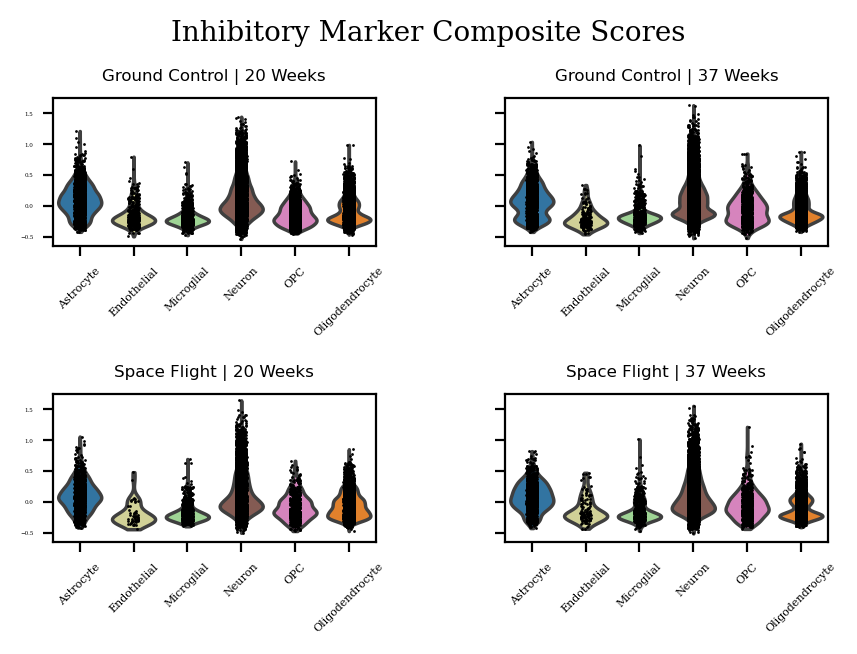

In [22]:
for x in mks_a_priori:
    # ggg = mks_a_priori[x].intersection(self.rna.var_names)
    # _ = self.plot(
    #     kind="violin", col_celltype=col_celltype, layer="scaled", genes=ggg,
    #     figsize=(len(ggg) * 2, len(ggg)), rotation=45, col_wrap=True,
    #     hspace=0.5 if len(ggg) < 10 else 1 if len(ggg) < 15 else 1.5,
    #     title=x, top=0.95)
    ggg = mks_a_priori[x].intersection(self.rna.var_names)
    sc.tl.score_genes(self.rna, gene_list=list(ggg),
                      layer="log1p", score_name=f"score_markers_{x}")
    _ = scflow.pl.plot_violin_by_group(
        self.rna, f"score_markers_{x}",
        fontsize={"title": "medium", "subtitle": 6, "x": 4,
                  "y": 2, "ylabel": None},
        col_celltype=col_celltype, col_condition=col_batch,
        layer="scaled", rotation=45, figsize=(5, 3), wspace=0.4,
        hspace=1, title=f"{x} Marker Composite Scores", top=0.85, sharey=True)

# SnC GEX

## Find GEX

In [28]:
mks = [pd.read_csv(os.path.join("gene_sets", i)).dropna(
    how="all", axis=1).assign(Source_File=i) for i in os.listdir("gene_sets")]
mks = [x.assign(Gene_Set=x["Source_File"].iloc[0].split("_2025")[0]) if (
    "pathway" in x) else x for x in mks]
mks = pd.concat(mks).drop("Unnamed: 0", axis=1).drop("row_id", axis=1)
mks = mks[mks.symbol.isin(self.rna.var_names)]
mks = mks[["Gene_Set", "symbol"]].set_index("Gene_Set").groupby(
    "Gene_Set").apply(lambda x: x["symbol"].to_list())
marker_genes_dict = dict(mks)
marker_gene_sets = mks.copy()
print(marker_gene_sets)

ggg = list(set(marker_gene_sets.loc["Senmayo"]).intersection(
    self.rna.var_names))

gex = self.rna.obs[[col_batch, col_sample, col_condition,
                    col_age, col_celltype,
                    "Senescent_Cell_Label", "Senescent_Cell_Label_by_Type"]
                   ].join(sc.get.obs_df(self.rna, ggg))
gex

Gene_Set
GOBP_CELLULAR_RESPONSE_TO_IRON_ION                                                                                                                                                                                                                          [B2m, Bmp6, Gpld1, Ireb2, Tfrc, Trf]
GOBP_CENTRAL_NERVOUS_SYSTEM_MYELIN_FORMATION                                                                                                                                                                                                      [Abca2, Ckap5, Cntn1, Ercc2, Mag, Mios, Tenm4]
GOBP_INTRACELLULAR_IRON_ION_HOMEOSTASIS                                                                                                                                                      [Abcb7, Aco1, Atp13a2, Atp6ap1, Atp6v0a2, Atp6v0d1, Atp6v1a, Atp6v1g1, B2m, Bmp6, Bmyc, Bola2, C...
GOBP_IRON_COORDINATION_ENTITY_TRANSPORT                                                                                     

Group                       sample       Condition   Age_End annotation_scanvi Senescent_Cell_Label Senescent_Cell_Label_by_Type  Sema3f  Csf1  Pigf  Igfbp5    Igfbp4  Pecam1  Igfbp7       Cd9     Vegfc    Acvr1b      Ets2  Lcp1  \
AAACAGCCAATCGCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4  Ground Control  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  0.000000  0.000000  0.000000  0.000000   0.0   
AAACAGCCAGCACCAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4  Ground Control  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  0.000000  0.000000  0.000000  0.000000   0.0   
AAACAGCCAGGTTCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4  Ground Control  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  0.000000  0.000000  1.210664  0.000000   0.0   
AAACAGCCATCAATCG-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4  Ground Control  20 Weeks   Oligodendrocyte        Non-Senescent              Oligodendrocyte     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  1.804370  0.000000  0.000000  0.000000   0.0   
AAACAGCCATGTCAAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4  Ground Control  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  0.000000  0.000000  0.000000  0.000000   0.0   
...                                                                   ...                          ...             ...       ...               ...                  ...                          ...     ...   ...   ...     ...       ...     ...     ...       ...       ...       ...       ...   ...   
TTTGTGTTCCCTGATC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  0.000000  0.000000  0.584253  0.584253   0.0   
TTTGTGTTCCGTAAAC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.505784     0.0     0.0  0.000000  1.090195  0.000000  0.505784   0.0   
TTTGTGTTCTGTGCAG-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  0.000000  0.000000  0.312697  0.312697   0.0   
TTTGTTGGTGTTAGCA-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight  20 Weeks   Oligodendrocyte        Non-Senescent              Oligodendrocyte     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  2.701263  0.000000  0.000000  0.000000   0.0   
TTTGTTGGTTAAGTGT-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight  20 Weeks            Neuron        Non-Senescent                       Neuron     0.0   0.0   0.0     0.0  0.000000     0.0     0.0  0.000000  0.741069  0.000000  1.162011   0.0   

                                                  Ctnnb1      Wnt2  Inha  Hgf     Hmgb1  Mmp14     Vegfa  Fgf1  Serpine2    Iqgap2       Jun    Nap1l4      Kitl  Plat  Egfr  Selplg     Il6st    Igfbp6  Angpt1     Timp2     Itpka       Mif      Nrg1  Ptbp1  Igfbp2  Il18       Vgf   Tubgcp2  \
AAACAGCCAATCGCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   0.000000  0.000000   0.0  0.0  0.000000    0.0  0.000000   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   0.0  

## Plot GEX

### All Cell Types + SnCs

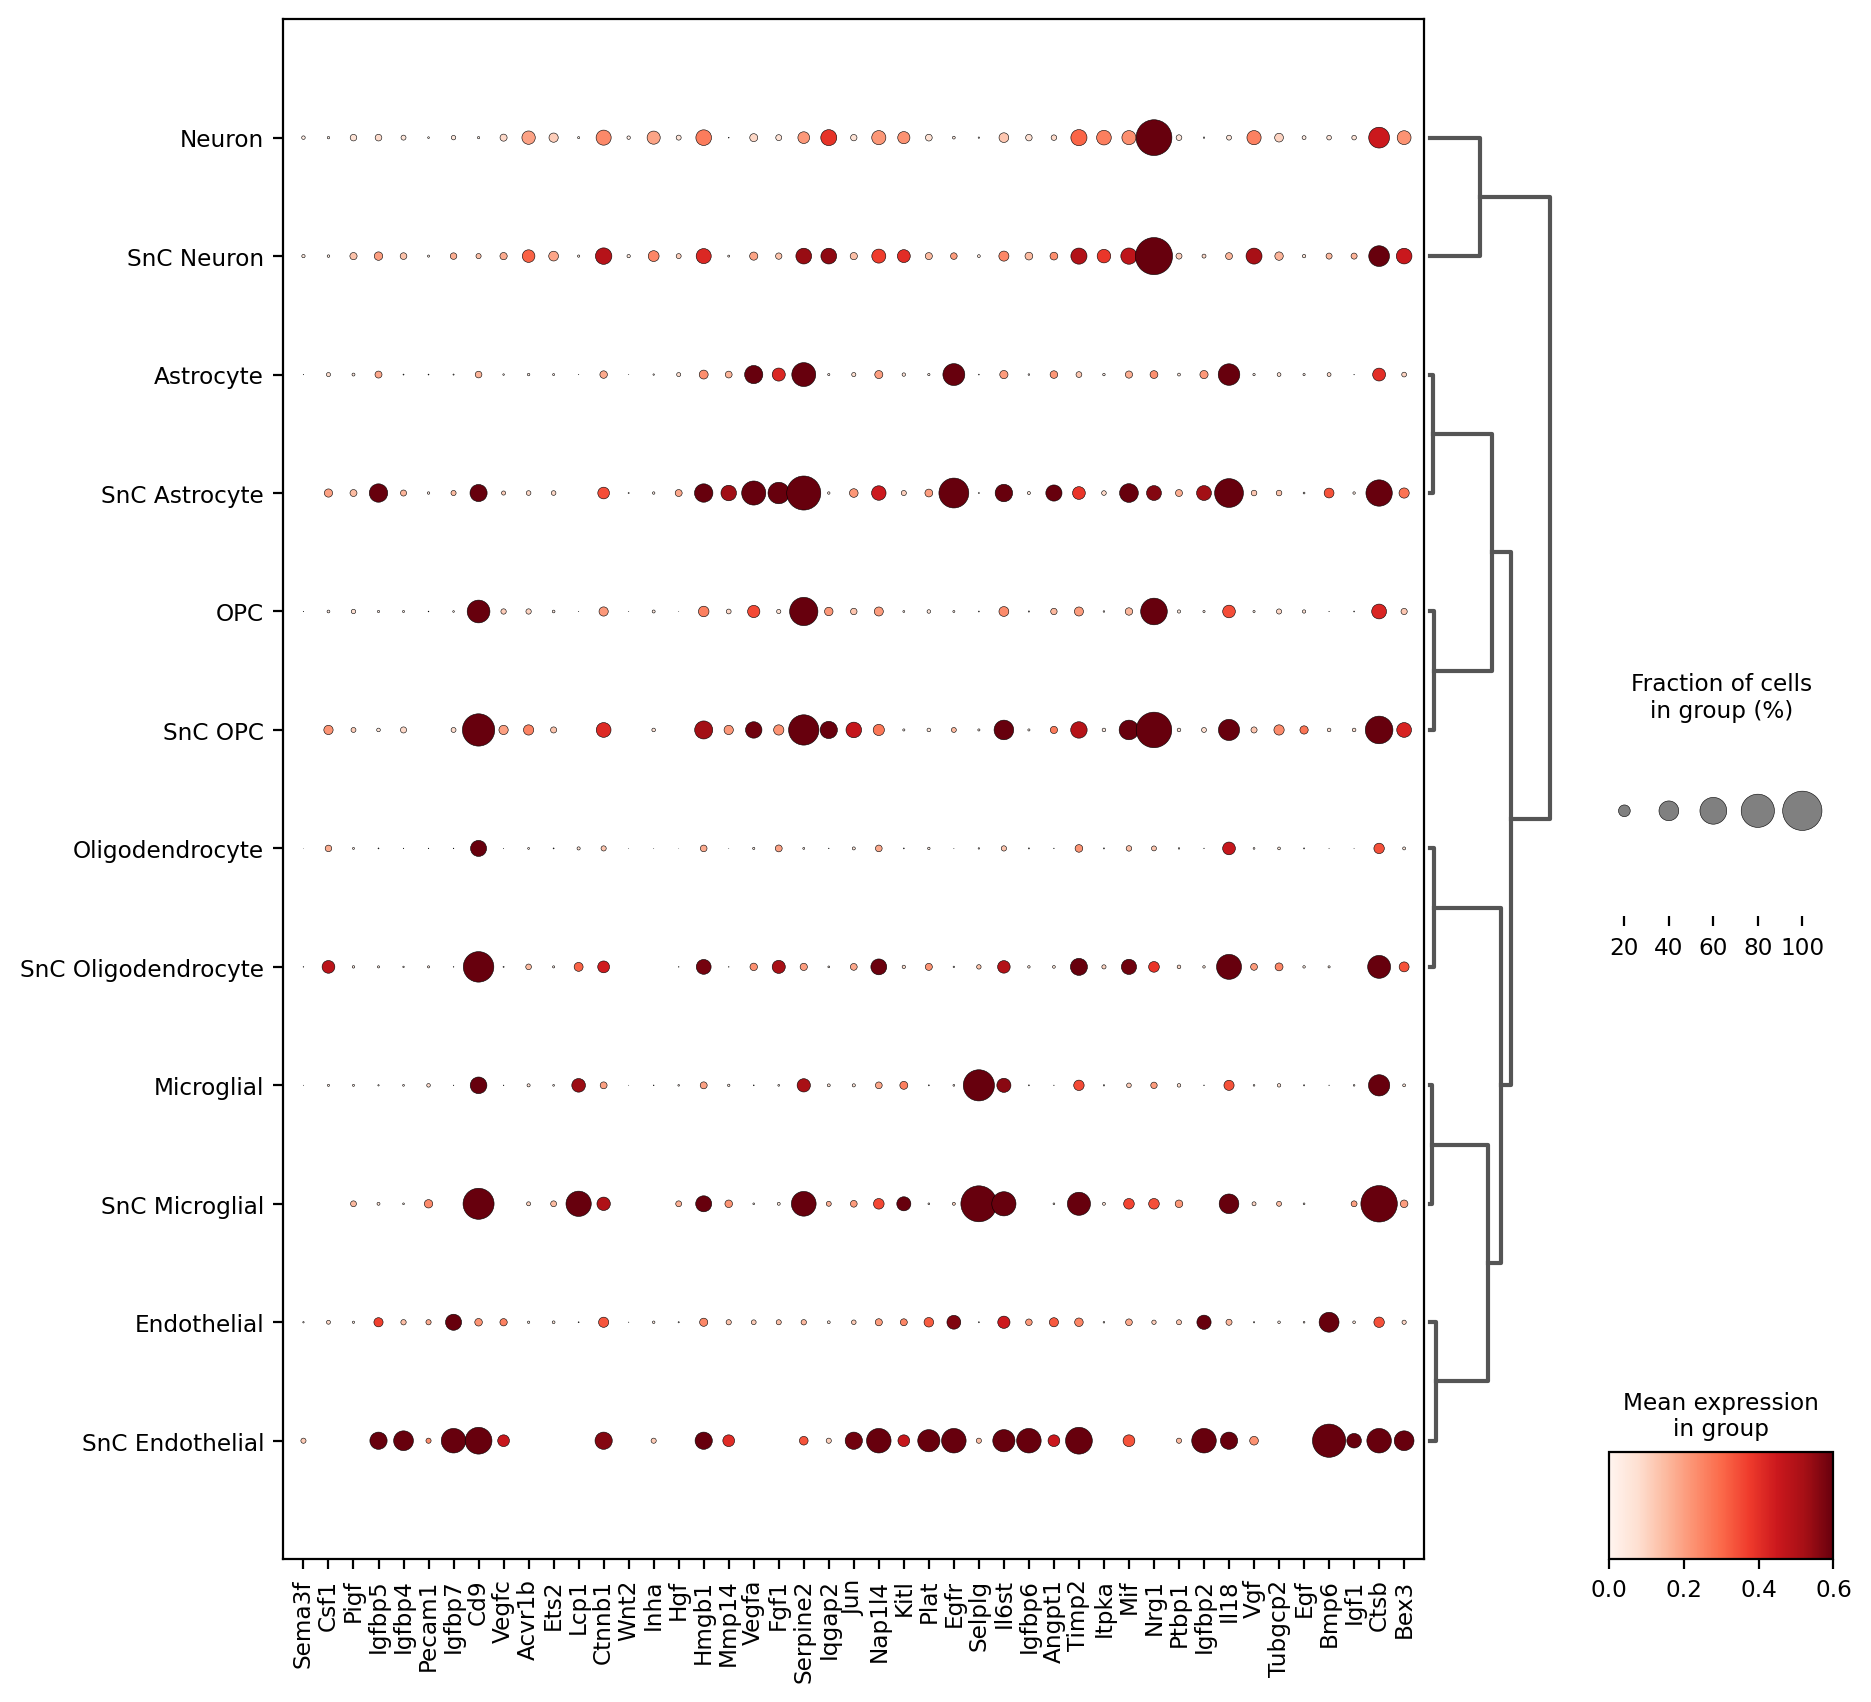

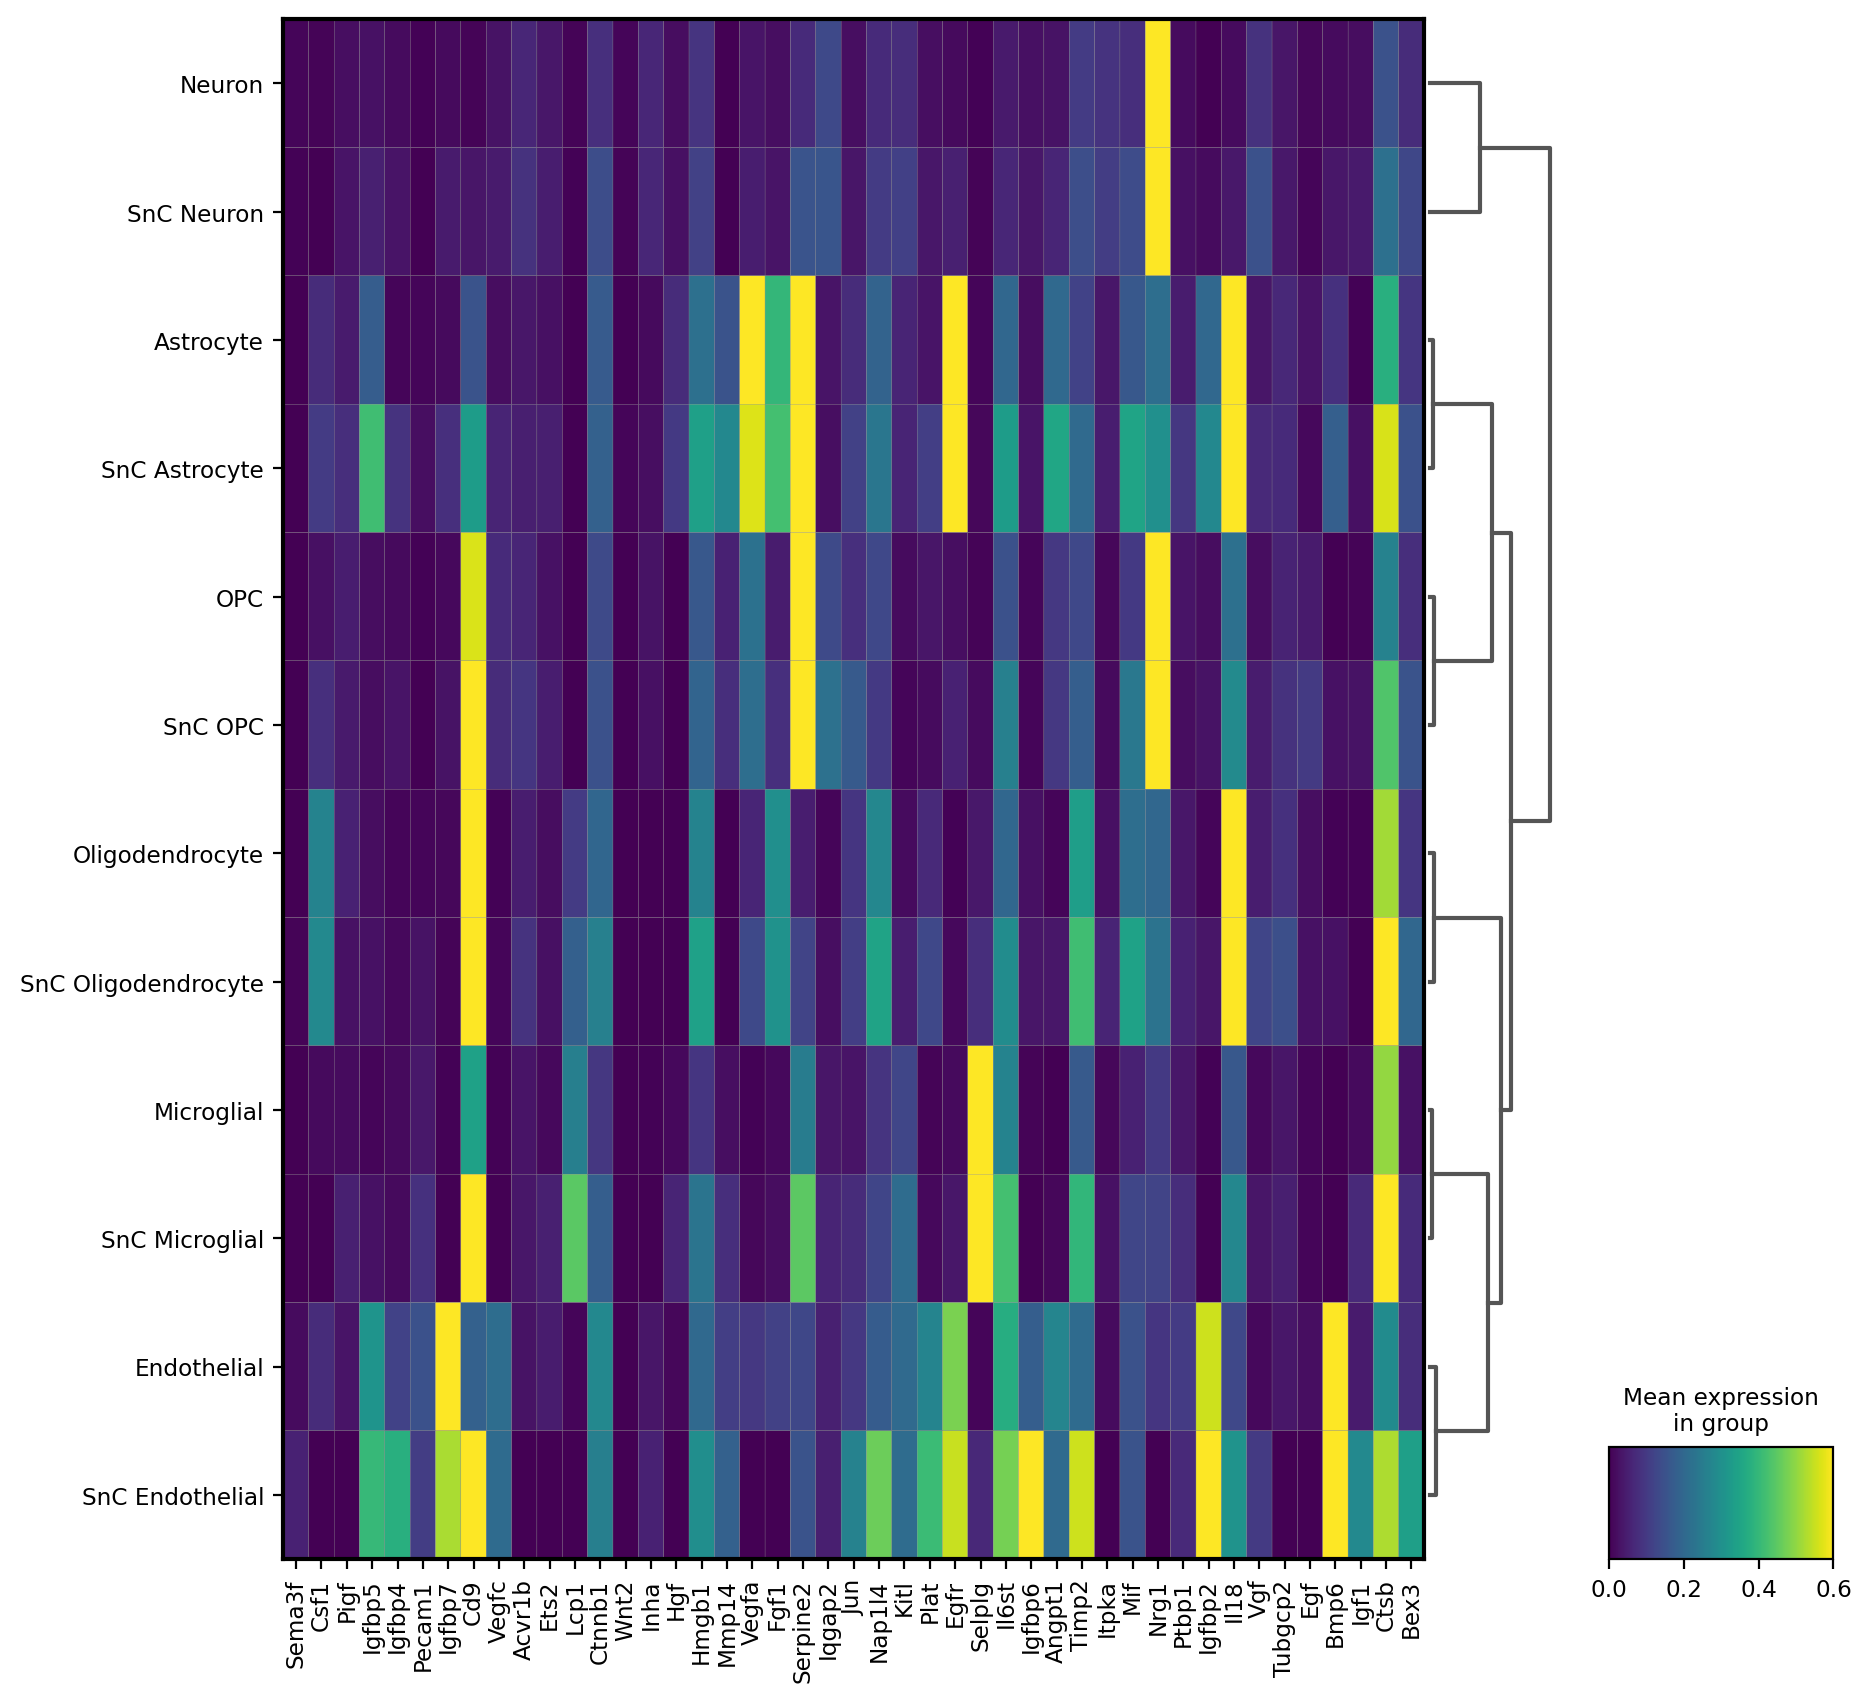

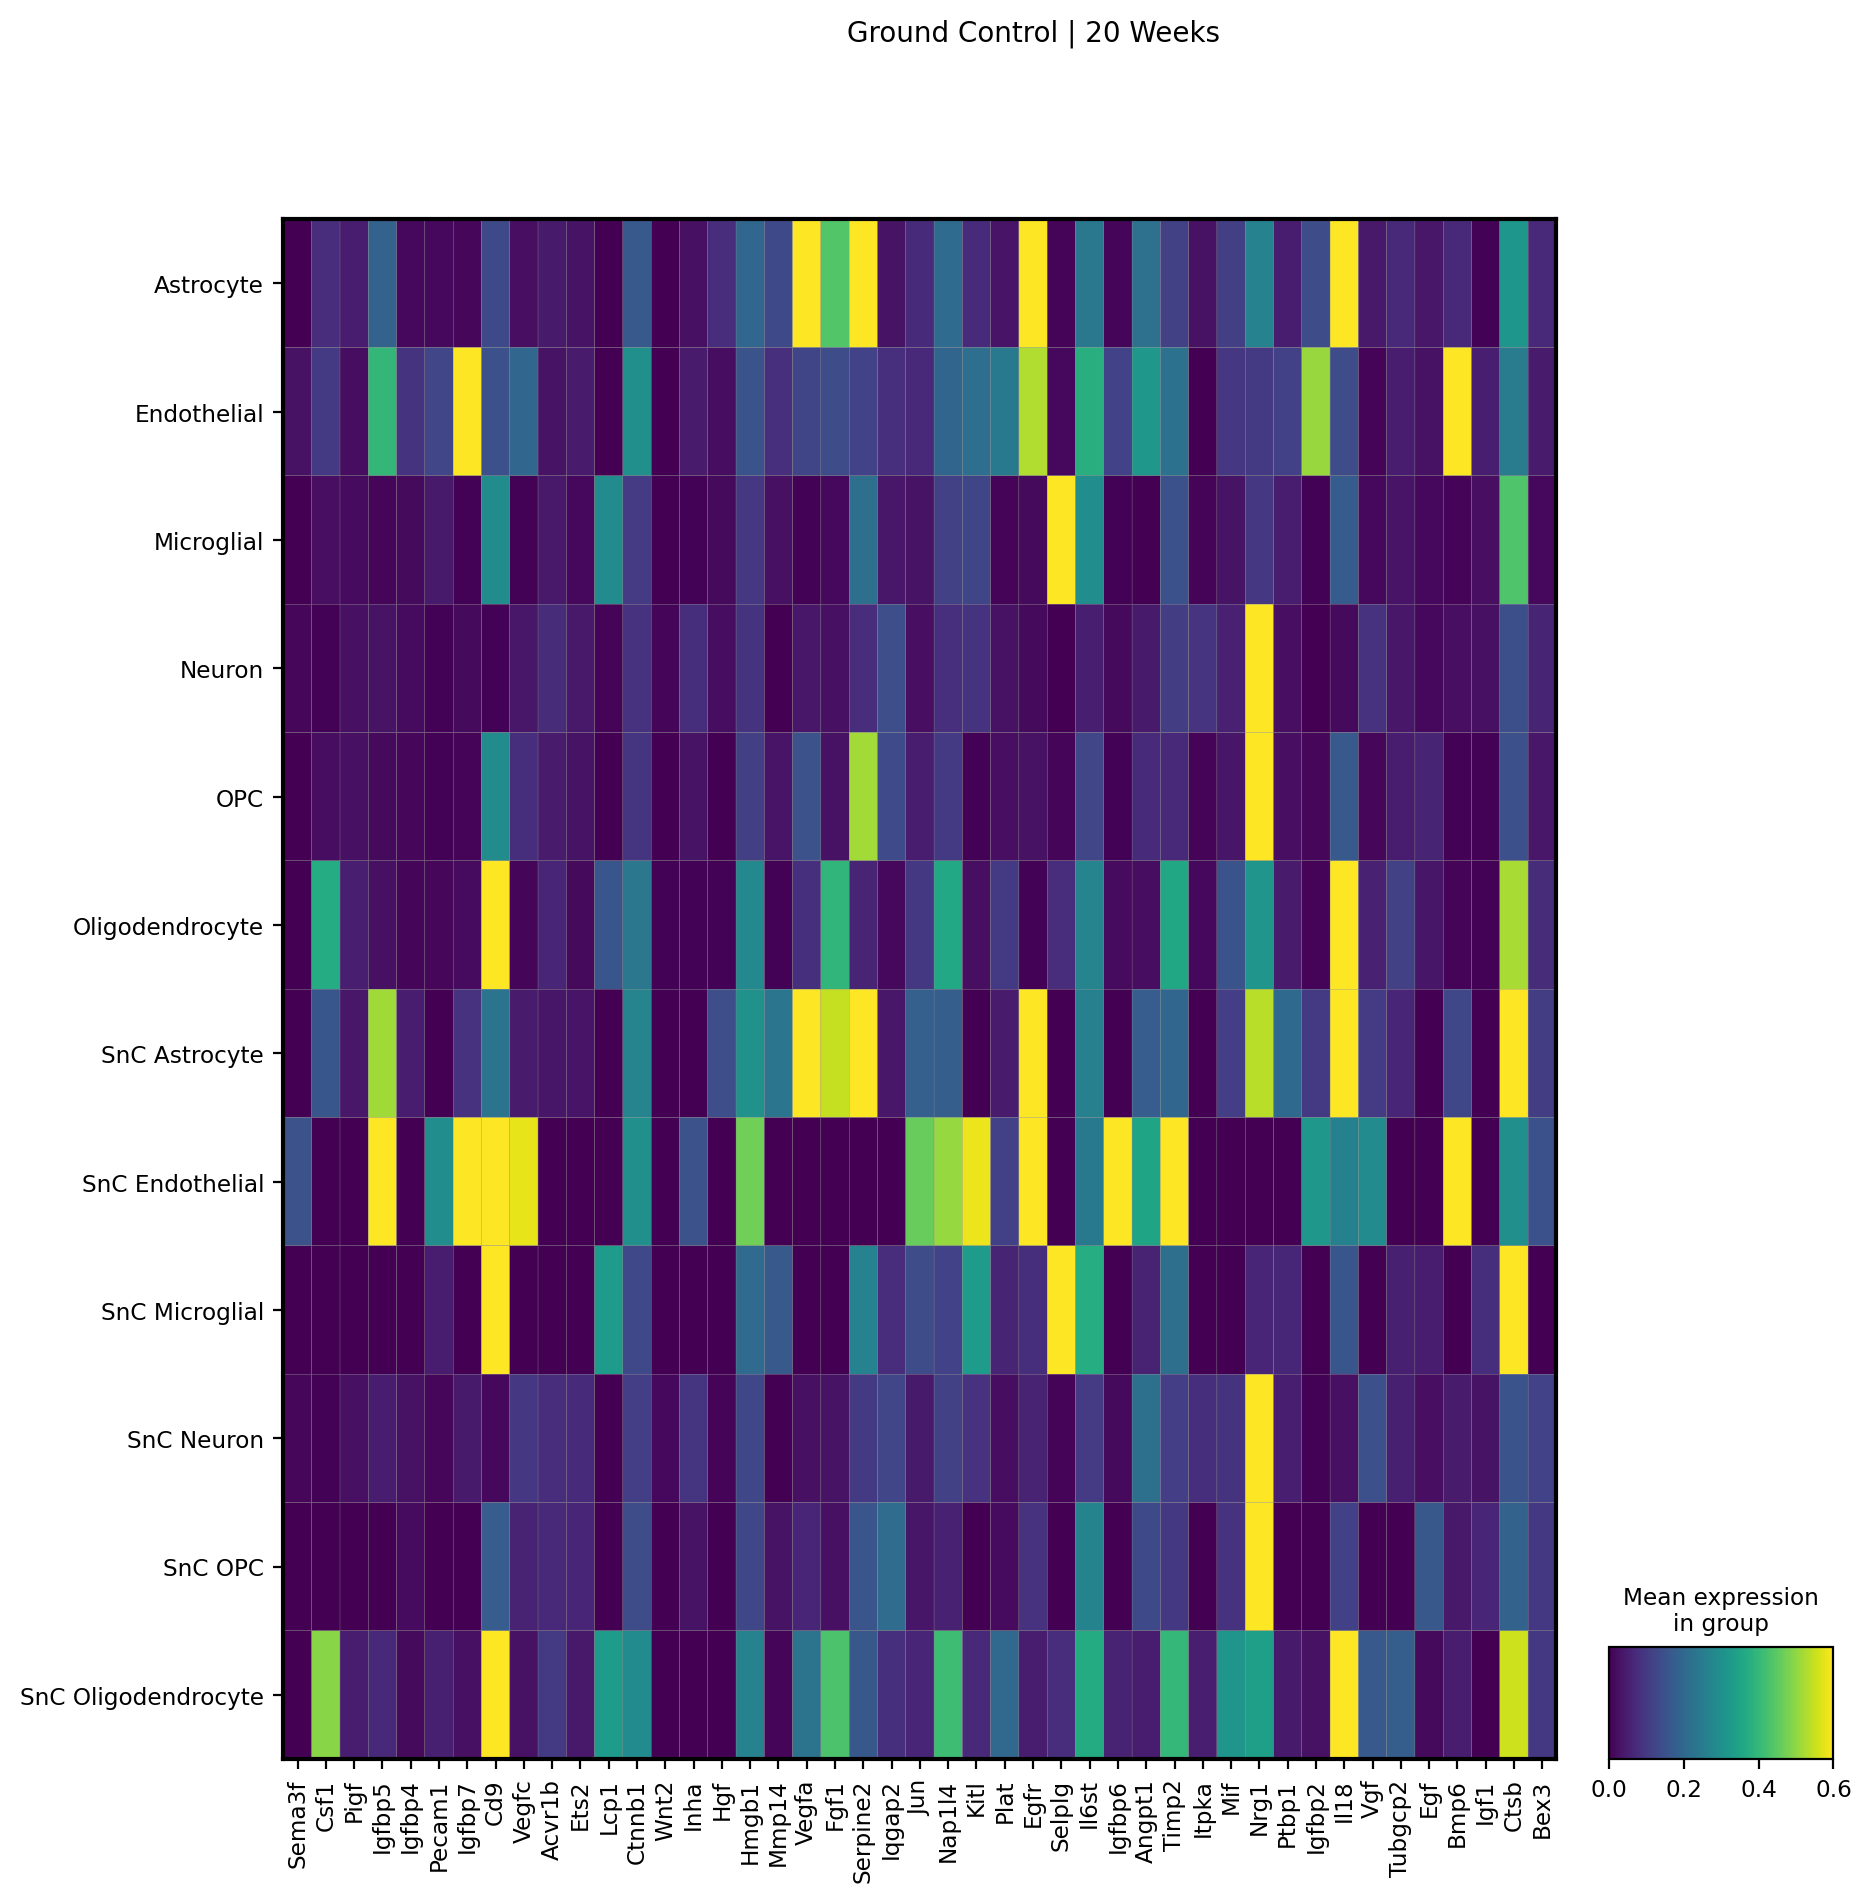

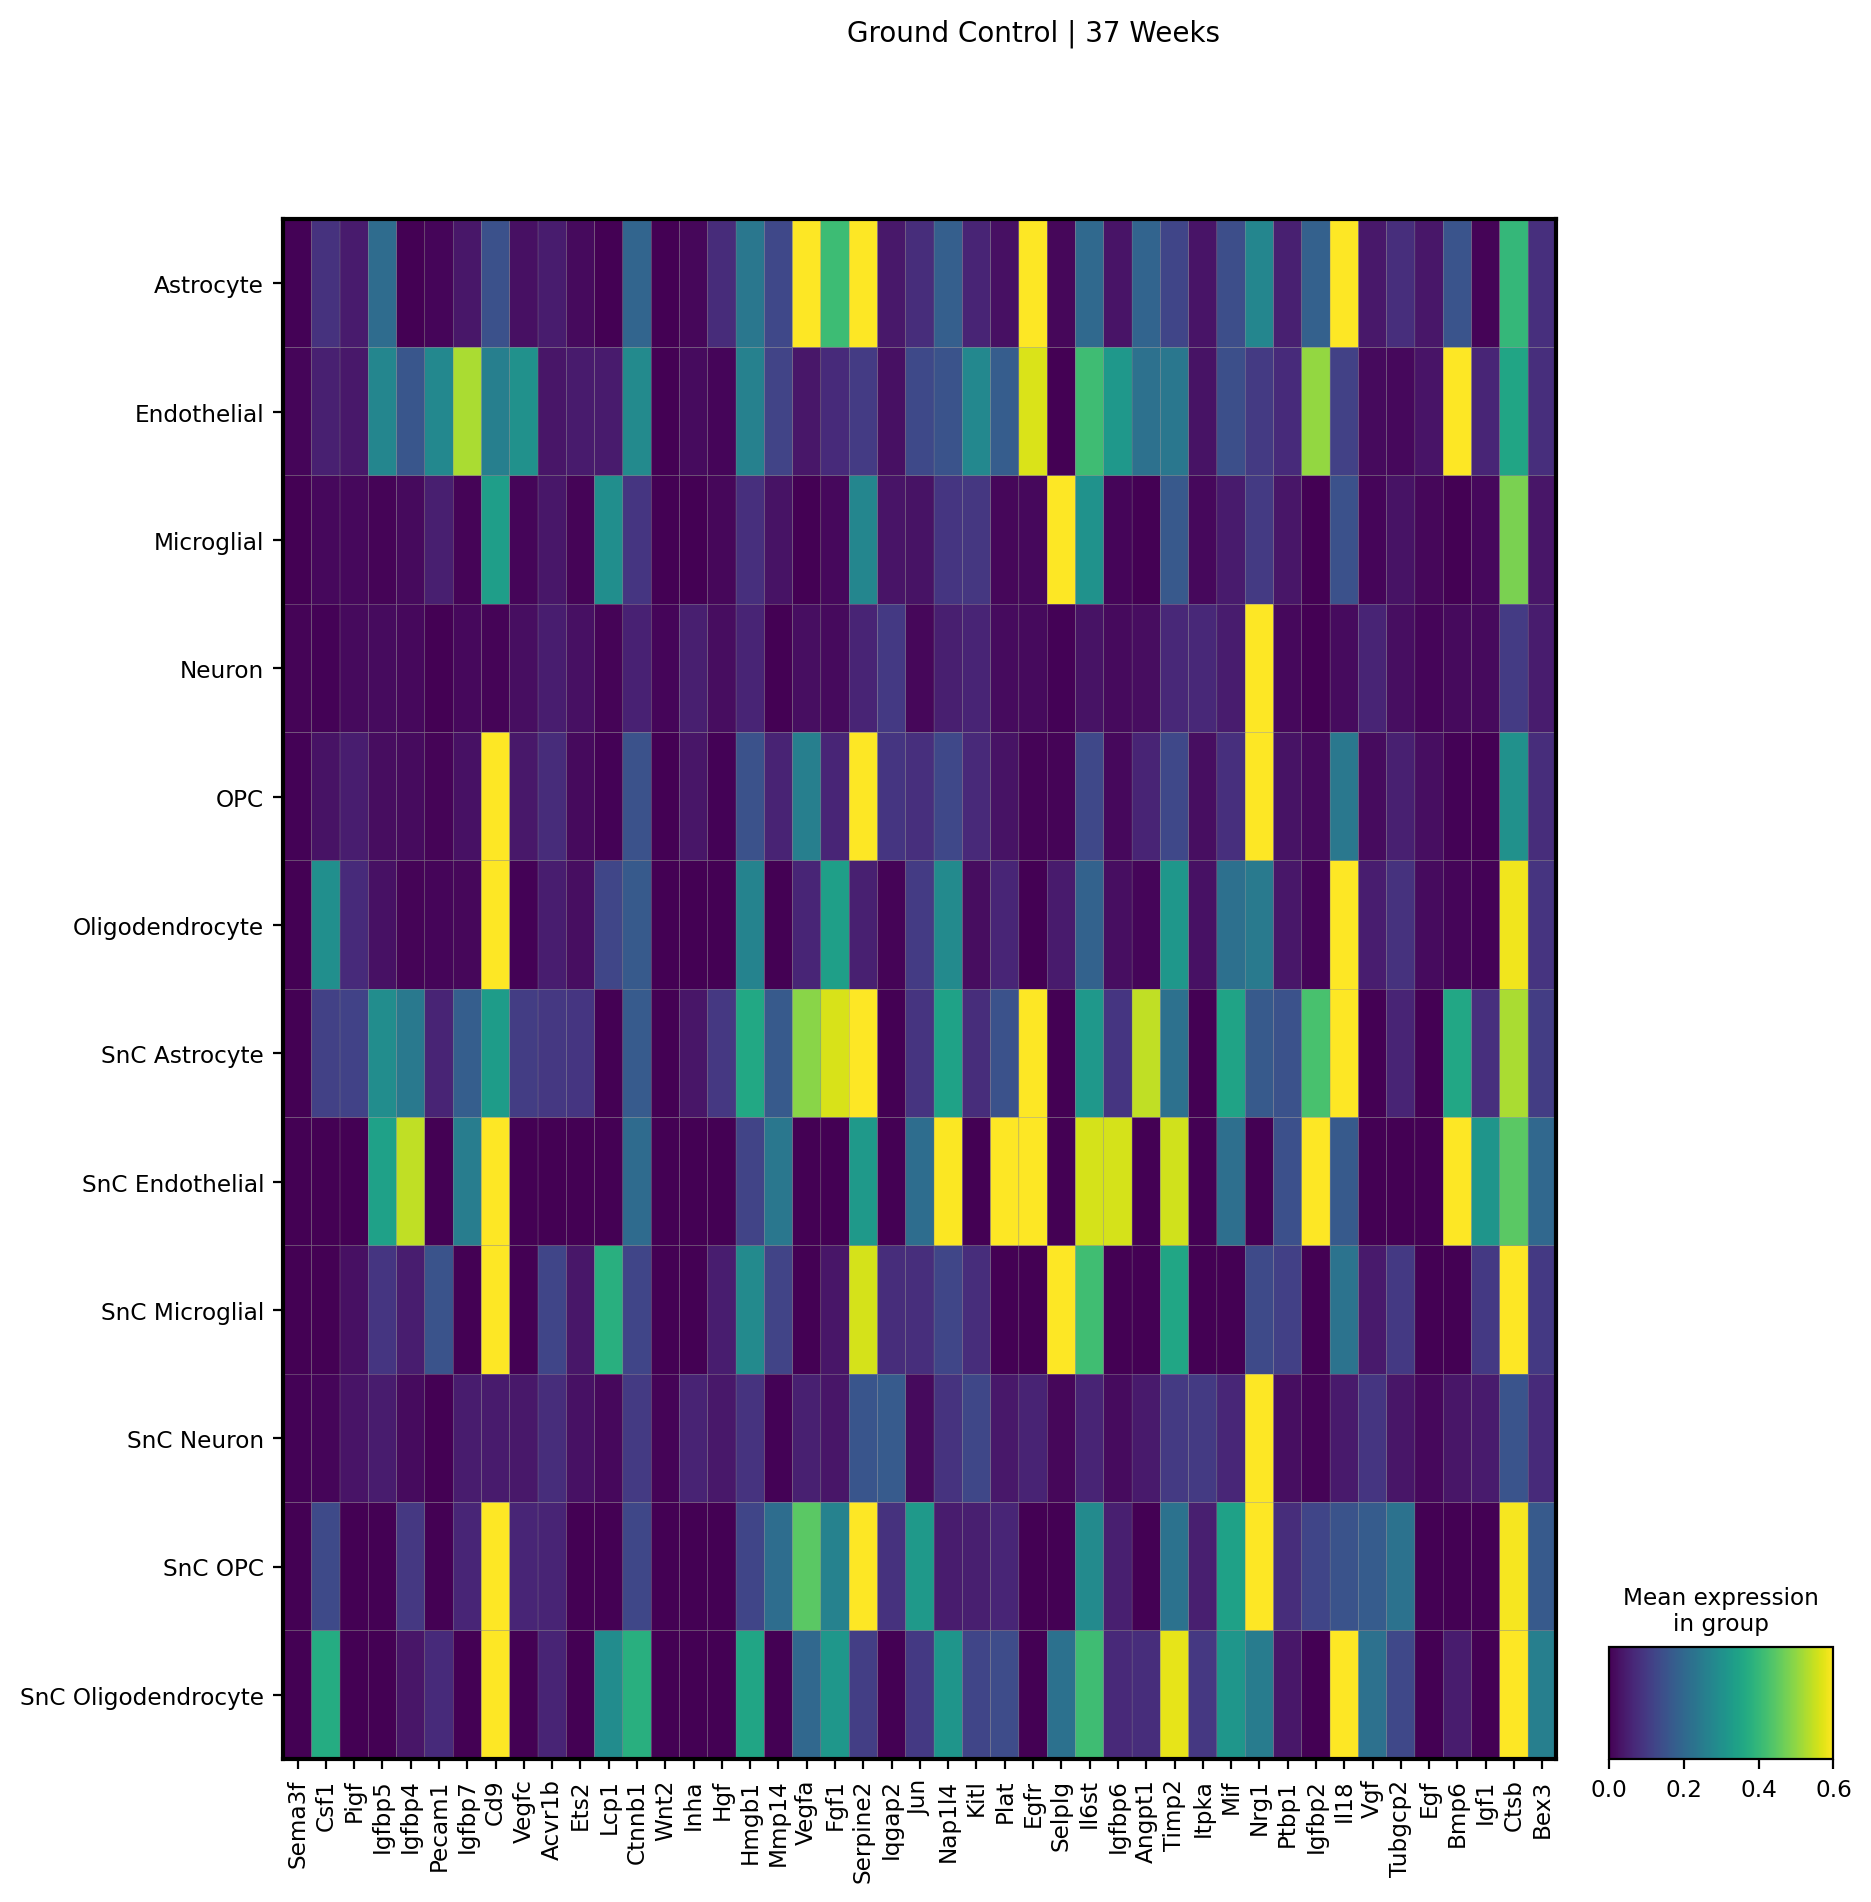

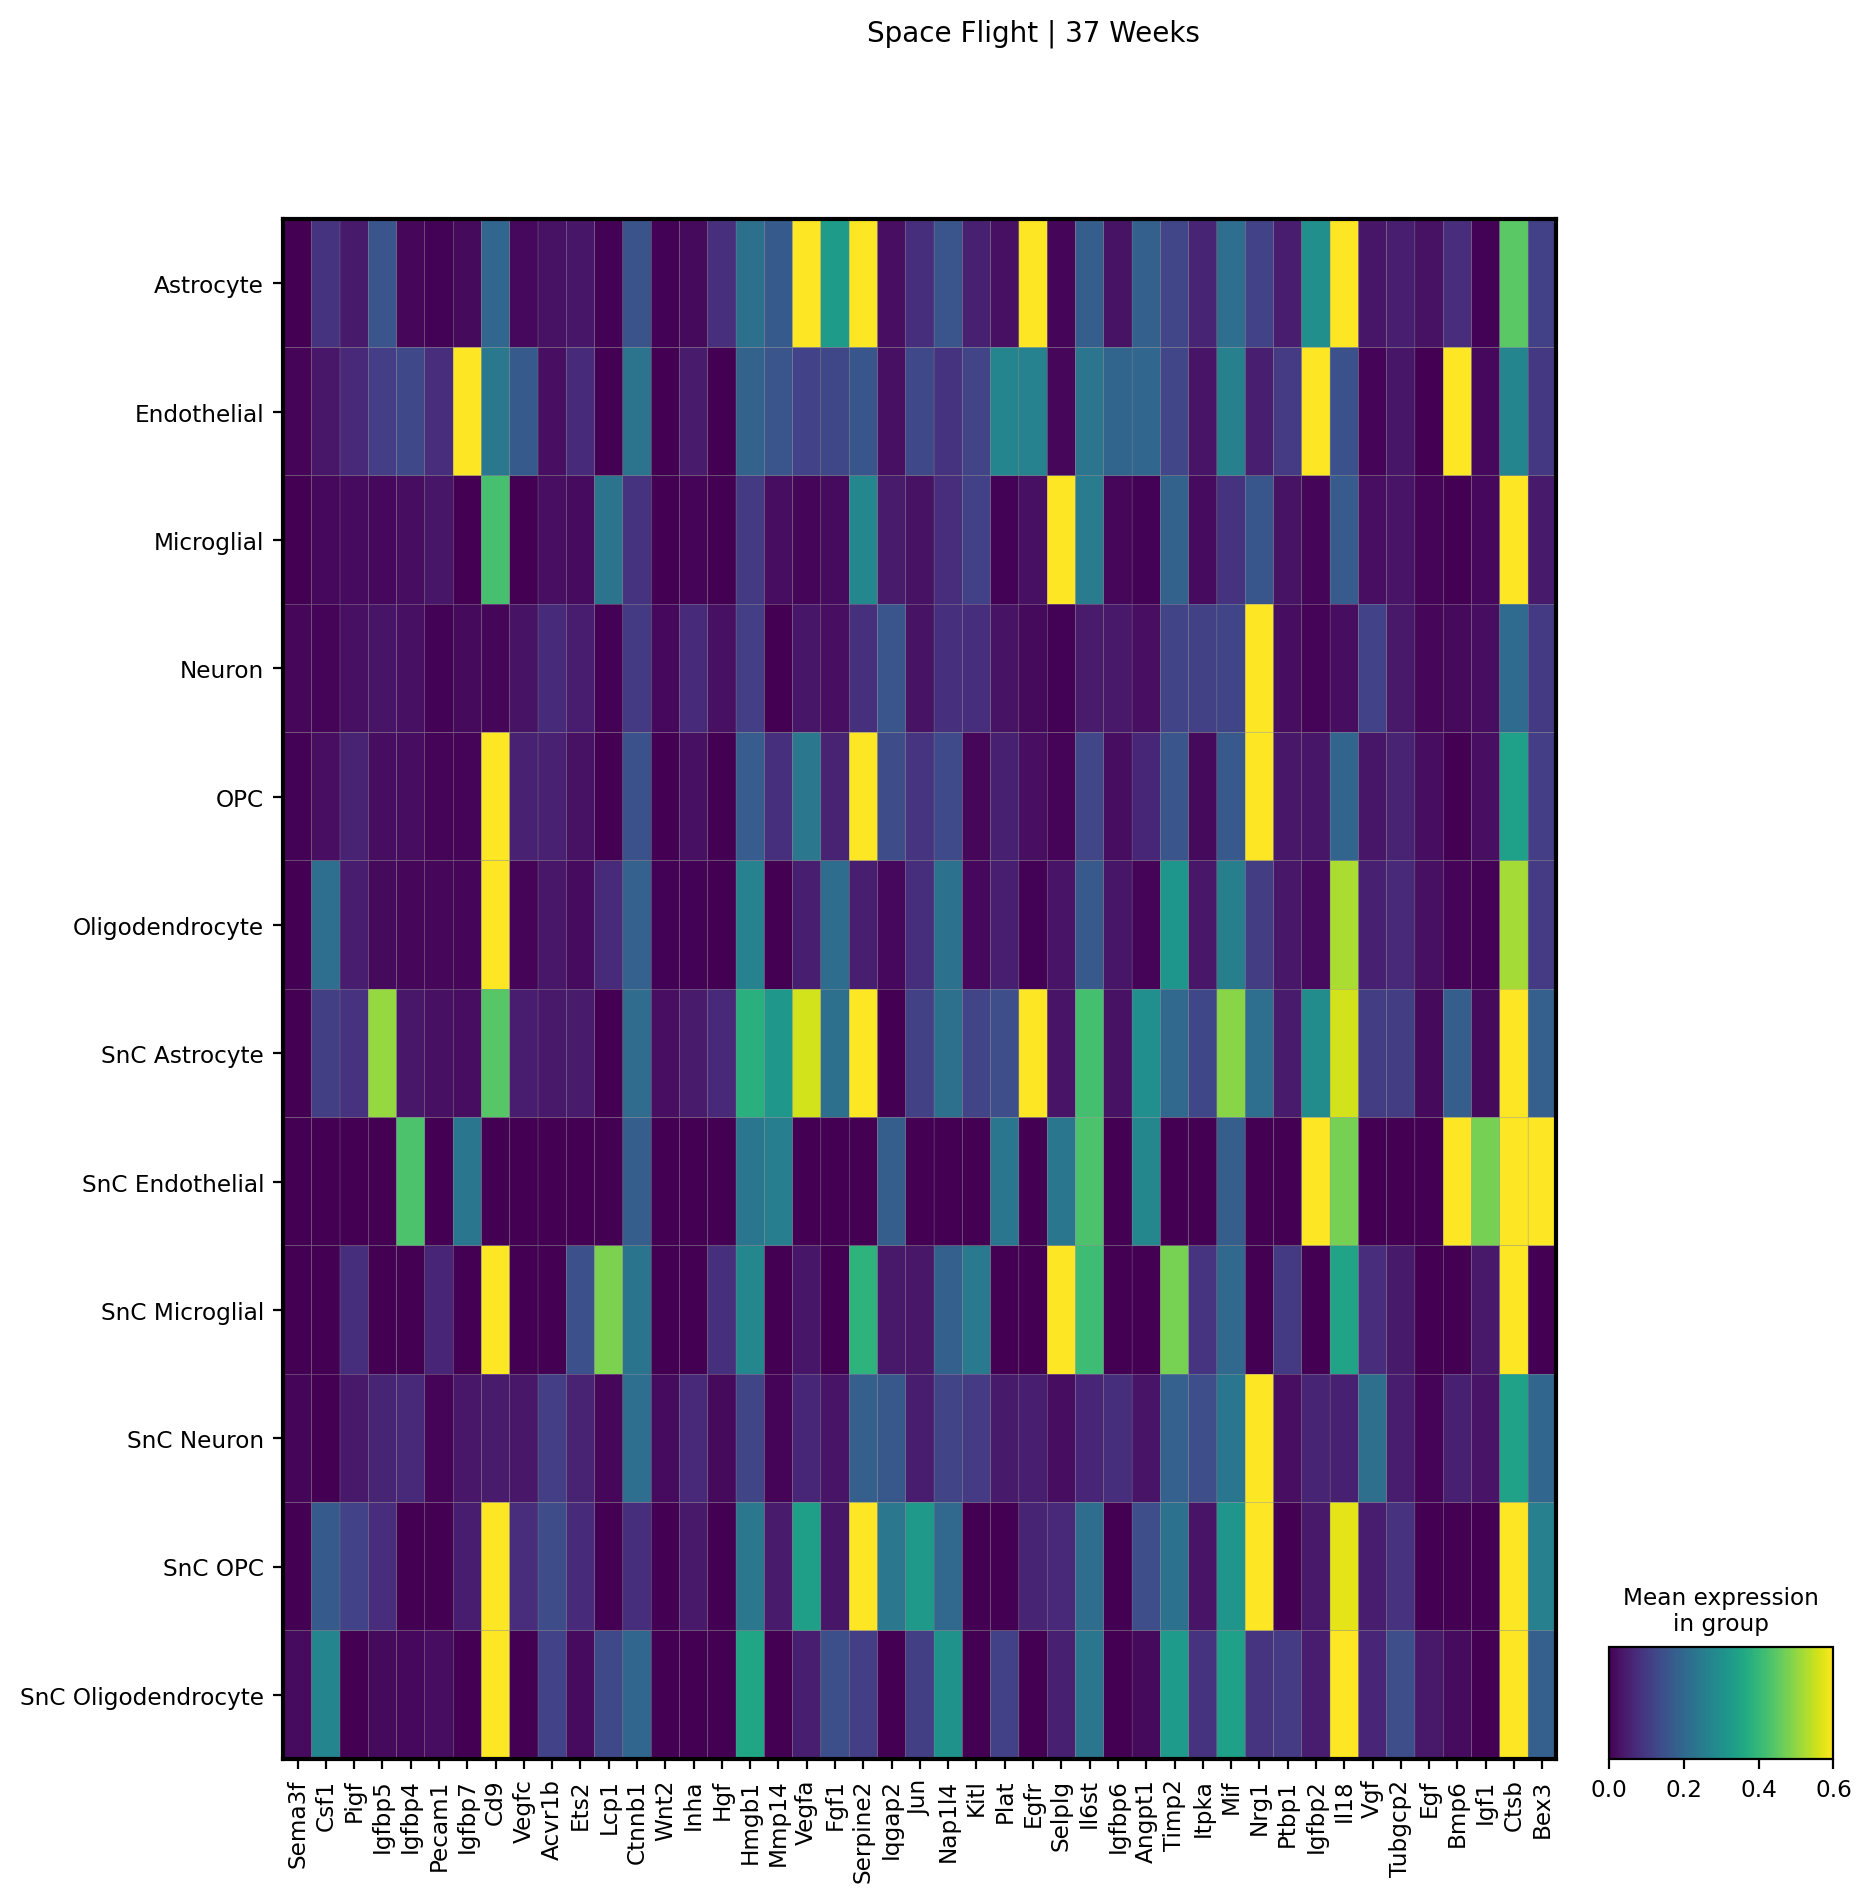

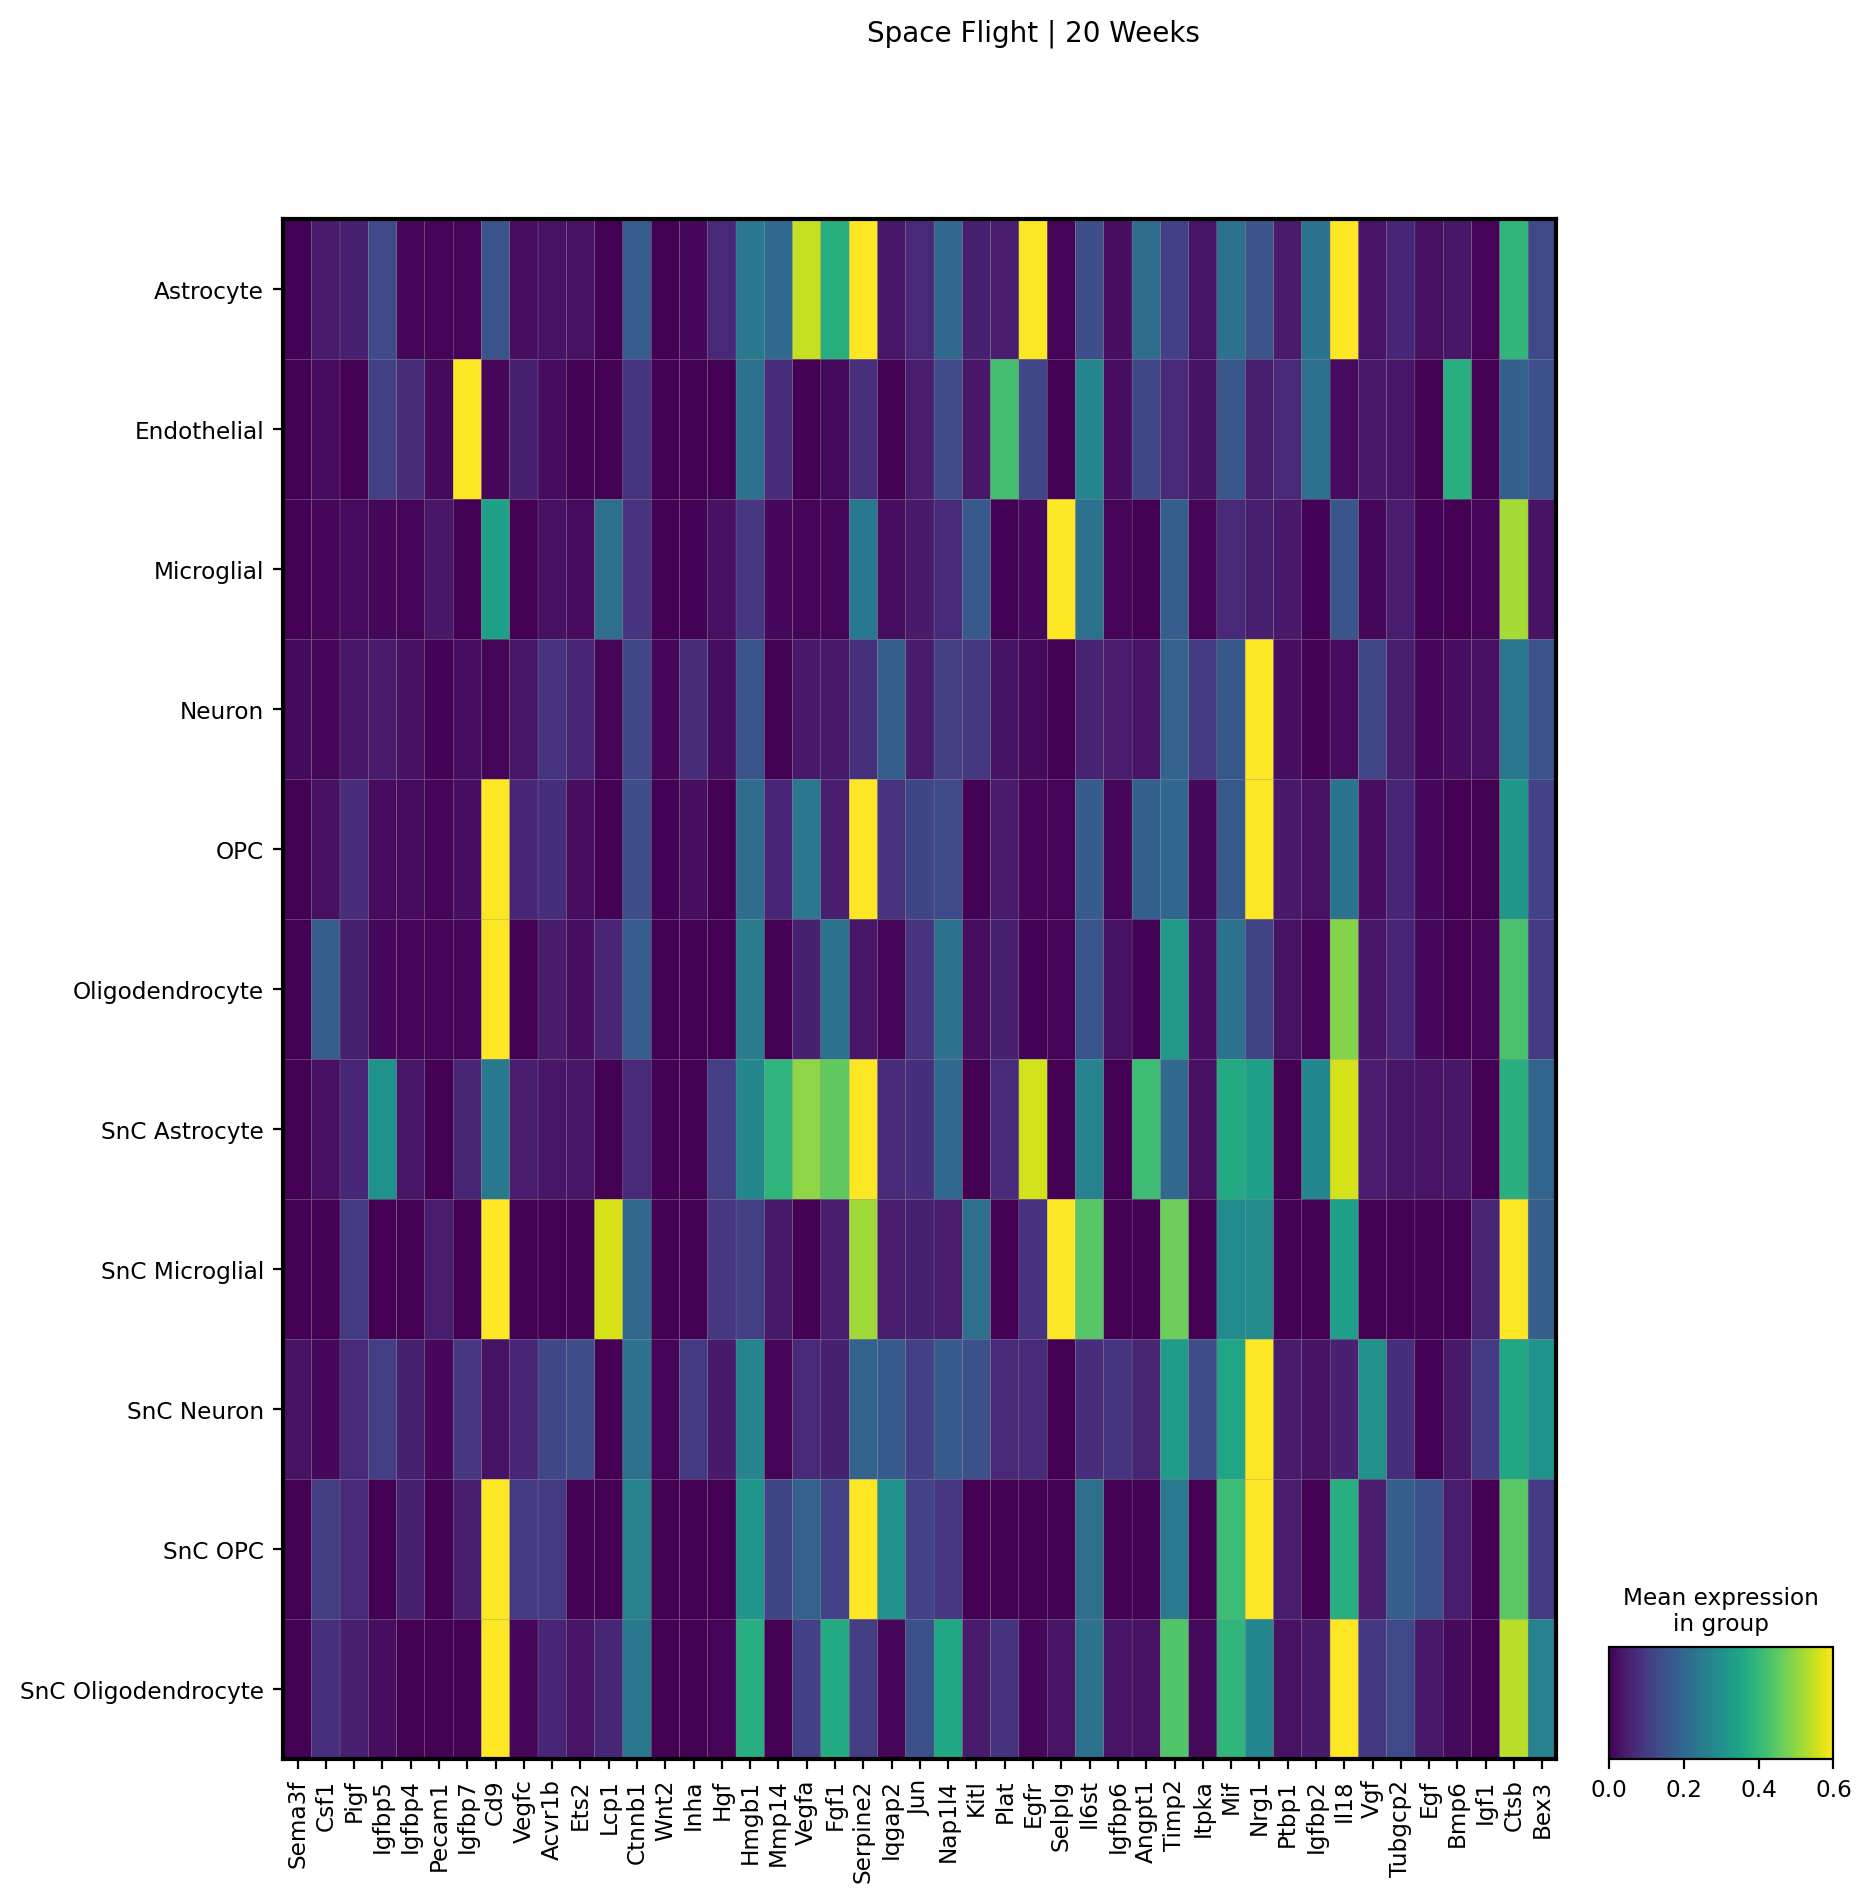

In [29]:
gex = self.rna.obs[[col_batch, col_sample, col_condition, col_age]].join(
    sc.get.obs_df(self.rna, ggg))
fig = self.plot(genes=ggg, figsize=(10, 10), vmax=0.6,
                col_celltype="Senescent_Cell_Label_by_Type",
                layer="log1p", standard_scale="obs",
                kind=["dot", "matrix"], dendrogram=True)
fig = self.plot(genes=ggg, figsize=(10, 10), vmax=0.6,
                col_celltype="Senescent_Cell_Label_by_Type", layer="log1p",
                by_group=col_batch, standard_scale="obs", kind="matrix")

### Just SnCs

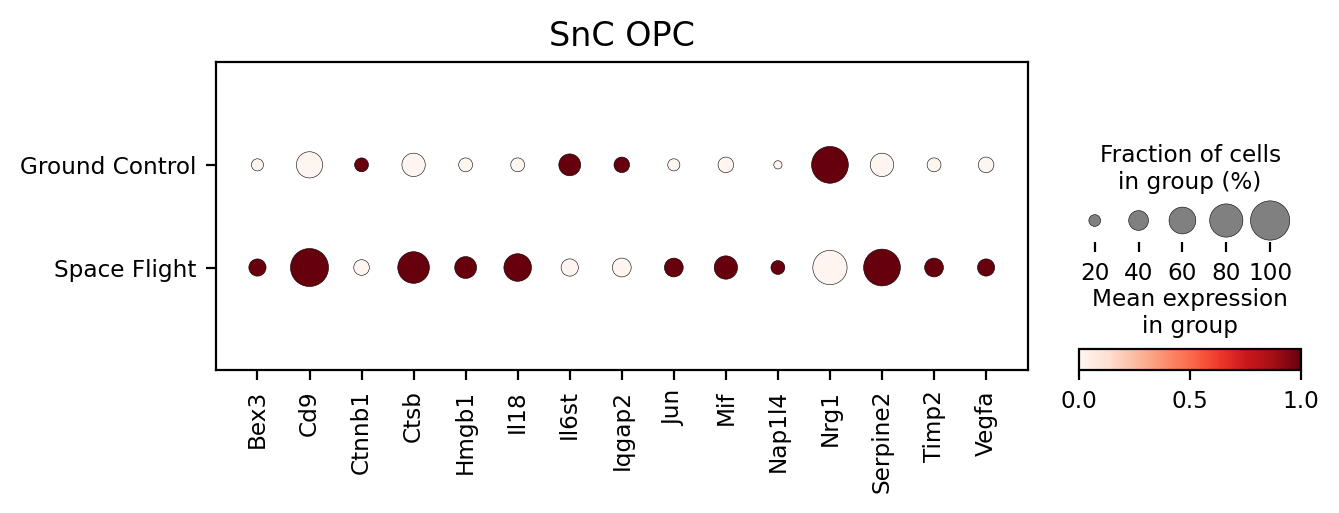

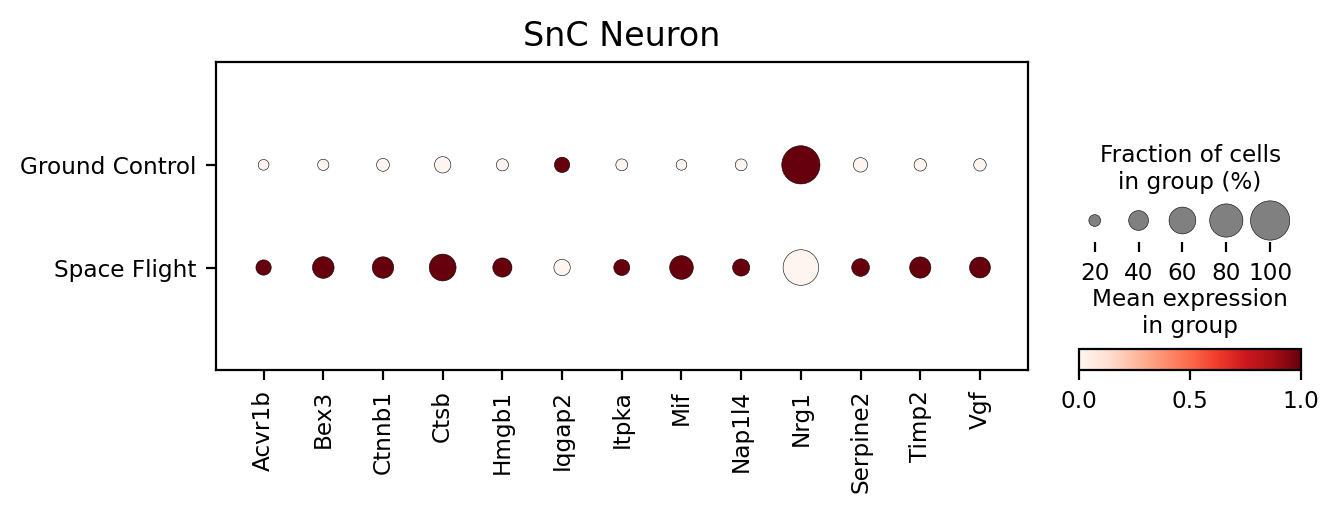

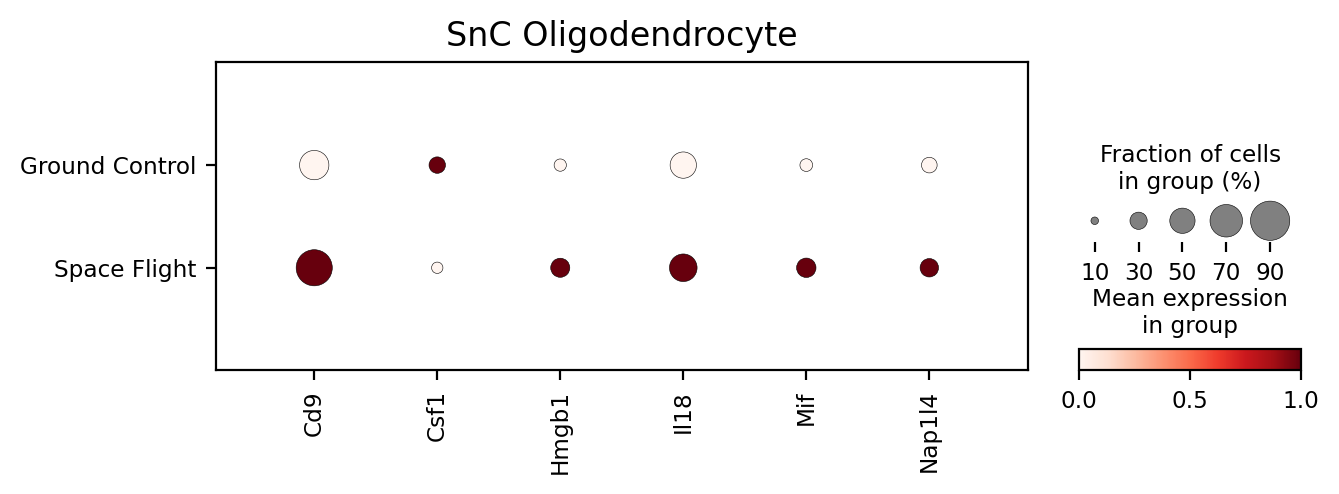

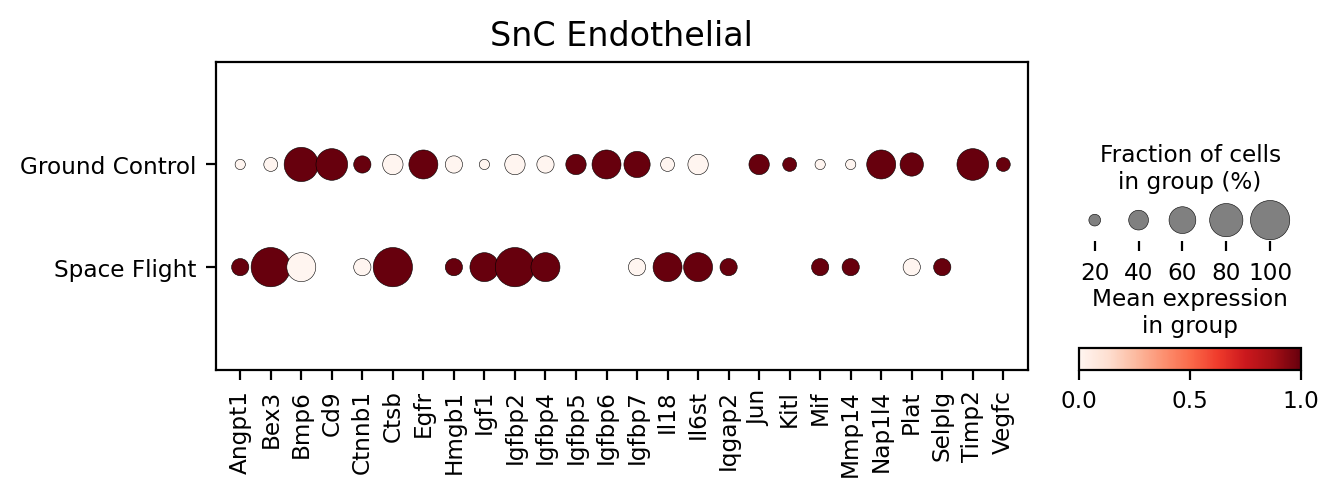

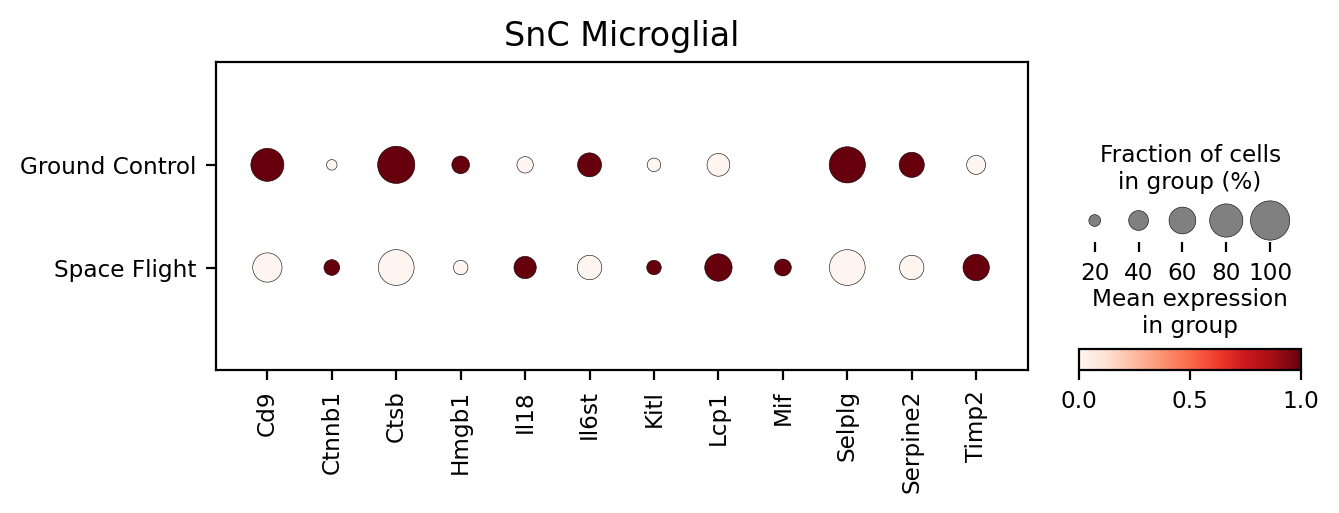

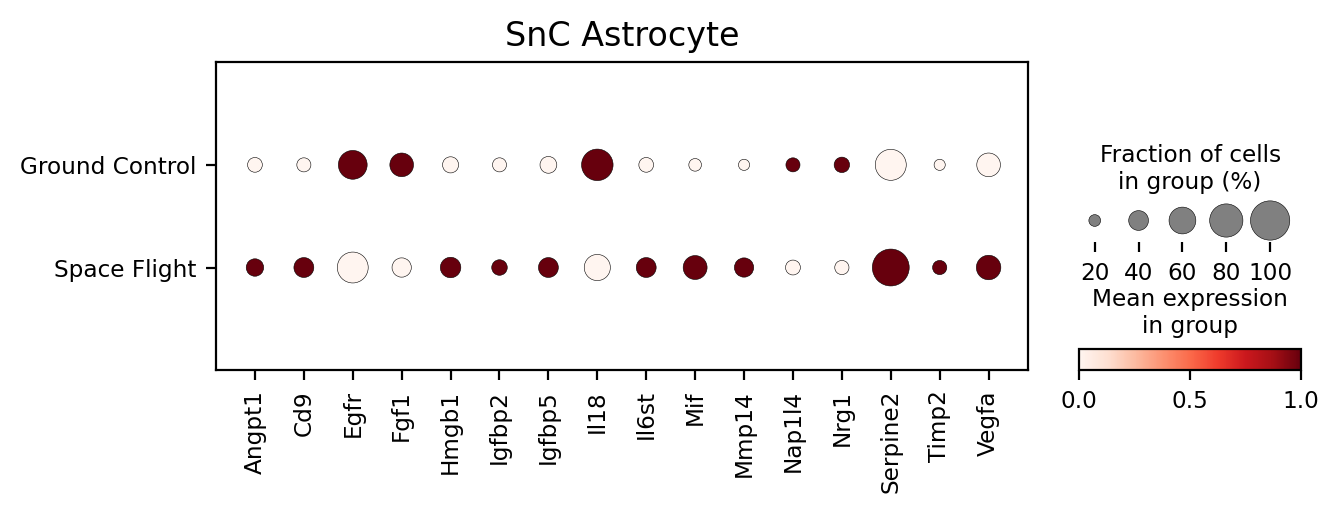

In [86]:
self.rna.X = self.rna.layers["scaled"].copy()
snc_cts = self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"].obs[
    "Senescent_Cell_Label_by_Type"].unique()
for x in snc_cts:
    gex_snc = self.rna[self.rna.obs["Senescent_Cell_Label_by_Type"] == x].obs[
        [col_batch, col_sample, col_condition, col_age, col_celltype,
         "Senescent_Cell_Label", "Senescent_Cell_Label_by_Type"]].join(
             sc.get.obs_df(self.rna, ggg))
    # diff_oldgc = gex_snc.groupby(col_condition).describe()[ggg].stack(0)[
    #     "75%"].unstack(0)[[group_order[0], group_order[-1]]].T.diff().loc[
    #         group_order[-1]]  # median GEX difference from young GC
    diff_oldgc = gex_snc.groupby(col_condition).describe()[ggg].stack(0)[
        "75%"].unstack(0).T.diff().iloc[1]  # median GEX difference from GC
    fig = self.plot(genes=diff_oldgc.index.values[diff_oldgc.abs() > 0.01],
                    figsize=(7, 2), col_celltype=col_condition, layer="log1p",
                    subset=self.rna.obs["Senescent_Cell_Label_by_Type"] == x,
                    title=x, standard_scale="var",
                    kind="dot")  # kind="violin")

# Annotation Comparison

In [ ]:
cols = list(pd.unique([col_celltype, "annotation_by_overlap",
                       "annotation_scanvi", "annotation_toppgene",
                       "annotation_majority_voting"]))
# cols += [i for i in [
#     "cellmap_class_name", "cellmap_subclass_name"] if i in self.rna.obs]
cols = [i for i in cols if i in self.rna.obs]
if len(mks_collapsed.keys()) <= 20:
    cmap = plt.get_cmap("tab20", len(mks_collapsed.keys()))
    colors = [cmap(i) for i in range(len(mks_collapsed.keys()))]
else:
    cmap = plt.get_cmap("hsv", len(mks_collapsed.keys()))
    colors = [cmap(i) for i in range(len(mks_collapsed.keys()))]
palette_umaps = dict(zip(mks_collapsed.keys(), colors))
for c in cols:
    cats = list(self.rna.obs[c].cat.categories)
    # Start with overlap from mks_collapsed
    overlap = [k for k in cats if k in mks_collapsed.keys()]
    colors = [palette_umaps[k] for k in overlap]
    # Assign new distinct colors for extras
    extras = [k for k in cats if k not in mks_collapsed.keys()]
    cmap = plt.get_cmap("tab20", len(extras))
    extra_colors = [cmap(i) for i in range(len(extras))]
    final_palette = dict(zip(overlap + extras, colors + extra_colors))
    self.rna.uns[f"{c}_colors"] = [final_palette[k] for k in cats]

# Plot UMAPs
self.plot(kind="umap", color=cols, wspace=0.3)

# Compare
self.rna.obs[cols].groupby(cols[0]).apply(
        lambda x: round(100 * x.value_counts(normalize=True), 1).sort_index(
                ).sort_values(ascending=False), include_groups=False)